# Examen Unidad 3

**Integrantes**

Acosta López Roberto Ismael - 18111958 \
Gaytan Bañuelos Ángel - 18111893 \
Valenzuela Rodriguez Axel Alejandro - 18111978 

## Importando librerias

Importamos las librerias que utilizaremos para todo el documento.

In [1]:
# Base
import pandas as pd
import numpy as np

# Librerias de graficación 
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de los datos
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder

# Detección de valores atipicos
from pyod.models.knn import KNN

# Selección de caracteristicas
from sklearn.feature_selection import RFE

# Separación datos de entrenamiento
from sklearn.model_selection import train_test_split 

# Para clasificación 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # Máquinas de vectores de soporte

#Evaluacion de rendimiento 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score 

Configuramos opciones de visualización tanto para los datos como para las graficas

In [2]:
#pd.options.display.max_columns = 10
#pd.options.display.max_rows = 10
firma_electronica = "Proceso_firma_electronica_completado"
nombre_columna_grafico = ""
titulo_grafico = ""

colores = ["red", "blue","orange", "green", "purple", "pink", "brown", "yellow", "cyan","gray","olive","darkslategray"]

arreglo_etiquetado = []
def convertir_etiquetas_binarias(data):
    if data == 0:
        arreglo_etiquetado.append("No")
    else:
        arreglo_etiquetado.append("Si")

def histogramas(dataframe):
    numero_color = 0
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,40))

    for i, ax in enumerate(axes.flat, start=0):
        ax.hist(x=dataframe.iloc[:,i].values, histtype="stepfilled", color=colores[numero_color], label= dataframe.iloc[:,i].name, align="mid" )
        ax.set_title(dataframe.iloc[:,i].name)
        ax.set_xlabel(dataframe.iloc[:,i].name)
        ax.set_ylabel('Número de personas')
        ax.legend()
        numero_color +=1
        if numero_color == len(colores):
            numero_color = 0 
            
    plt.show()

In [3]:
# Funciones que utilizaremos durante la redacción y aplicación del documento 
# Se utiliza junto con la función apply
mostrar = []
def calcular_atipicos_por_columna(serie):
    q25 = serie.quantile(q=.25)
    q75 = serie.quantile(q=.75)
    iqr = q75 - q25
    
    datos = serie[(serie<(q25-iqr)) | (serie>(q75+iqr))].index.values
    mostrar.append(datos)

## Cargando Dataset

In [4]:
df = pd.read_csv('Financial-Data.csv')
df_original = df

### Información sobre el dataset

El Dataset utilizado contiene una serie de registros de personas que solicitaron una Firma electrónica de préstamo, donde se hace un conteo de las personas que finalizaron el proceso de la Firma electronica haciendo una comparacion basada en su historial financiero.

Mediante esto se planea desarrollar un modelo de predicción el cual permita, mediante su historial financiero, laboral y datos personales extras, si es que la persona completara o no su proceso de Firma electronica.

### Contenido de las columnas:
El archivo CVS contiene detalles de usuarios los cuales comenzaron el proceso de Firma Electronica, teniendo resultados donde se finalizo el proceso, y otros donde el proceso no se concluyo correctamente. 

* **ID**: 
    Identificación del usuario - Cliente

* **Edad**: 
    Edad del usuario 

* **Tipo_de_salario**: 
    Con qué frecuencia se les paga a los solicitantes

* **Vivienda_propia**:
    * 0 = Vivienda alquilada
    * 1 = Propietario

* **Ingreso**: 
    Ingresos del solicitante

* **Tiempo_trabajado(meses)**:
    Cuantos meses lleva haciendo trabajo

* **Tiempo_trabajado(años)**:
    Cuantos años lleva haciendo trabajo 

* **Tiempo_en_vivienda_actual(años)**:
    Cuántos años se quedó una persona en la dirección actual

* **Tiempo_cuenta_personal(meses)**:
    Cuantos meses tiene esa persona una cuenta personal

* **Tiempo_cuenta_personal(años)**:
    Cuantos meses tiene esa persona una cuenta personal 

* **Tiene_deuda**:
    La persona tiene alguna deuda o no.

* **Cantidad_solicitada**:
    El usuario decidió solicitar

* **Puntuación_de_riesgo (Columnas de la 1 a la 5)**: 
    Puntuación que se le da al cliente para verificar si no es riesgoso hacer el tramite de la firma electrónica evaluado por 5 personas.

* **ext-quality_score (Columnas de la 1 a la 2)**: 
    Puntuacion que se le da al cliente para verificar si no es riesgoso hacer el tramite de la firma electronica evaluados por 2 personas externas al banco.

* **consultas_el_mes_pasado**:
    Cuantas consultas ha tenido el usuario en los últimos meses

* Proceso_firma_electronica_completado (**Columna objetivo**):
    * 1: Proceso de firma electrónica completado
    * 0: No completado el proceso de firma electrónica


### Detalles del dataset:
1. Los nombres de las columnas del dataset fueron interpretadas al español, para facilitar su comprensión.

### Meta Objetivo:
El objetivo principal es utilzizar un modelo de predicción para intentar buscar si el proximo(s) solicitante(s) completará(n) el proceso de firma electrónica o no.

### Método de resolución:
La problematica planteada se puede resolver bajo un modelo de clasificación.

## Entendiendo los datos

### Verificar los datos
Mediante el uso del método head podremos ver la informacion de las primeras 5 filas de datos de cada columna.

In [5]:
df.head()

,ID,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),...,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,7629673,40,bi-weekly,1,3135,0,3,3,6,2,...,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,3560428,61,weekly,0,3180,0,6,3,2,7,...,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,6934997,23,weekly,0,1540,6,0,0,7,1,...,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,5682812,40,bi-weekly,0,5230,0,6,1,2,7,...,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,5335819,33,semi-monthly,0,3590,0,5,2,2,8,...,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


### Eliminación de la columna ID
Podemos observar que la columna ID solo almacena el indice de cada uno de los datos, no forma parte de información relevante para aplicarlo en nuestro ejercicio, por lo que decidimos quitarla de la columna.

In [6]:
df.drop(columns=['ID'], inplace=True)
df.head()


,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,40,bi-weekly,1,3135,0,3,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,61,weekly,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,23,weekly,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,40,bi-weekly,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,33,semi-monthly,0,3590,0,5,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


### Columna Edad

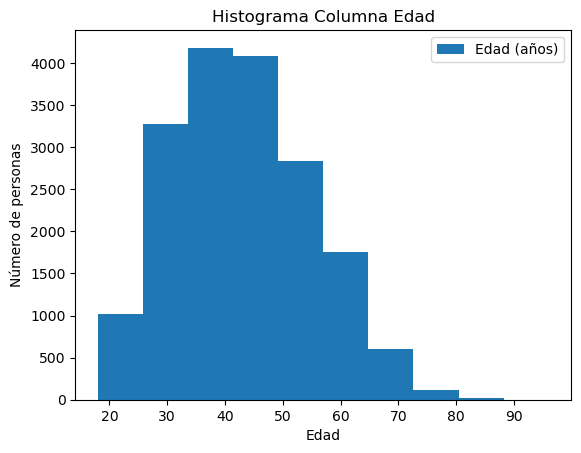

In [7]:
plt.rcdefaults()
plt.hist(x=df['Edad'].values, histtype="bar", label='Edad (años)', align="mid", rwidth=None)
plt.title('Histograma Columna Edad')
plt.xlabel('Edad')
plt.ylabel('Número de personas')
plt.legend()
plt.show()

En base a lo observado se puede decir que aproximadamente: 

* 1000 personas tienen entre 10-20 años.
* 3250 personas tienen entre 20-30 años. 
* 4100 personas tienen entre 30-40 años.  
* 4000 personas tienen entre 40-50 años. 
* 1800 personas tienen entre 50-60 años.
* 700 personas tienen entre 60-70 años. 
* 100 personas tienen entre 70-80 años. 
* 10 personas tienen entre 80-90 años.


### Columna Tipo Salario

In [8]:
frecuencias_tipo_de_salario = df.Tipo_de_salario.groupby(by=df.Tipo_de_salario).count()

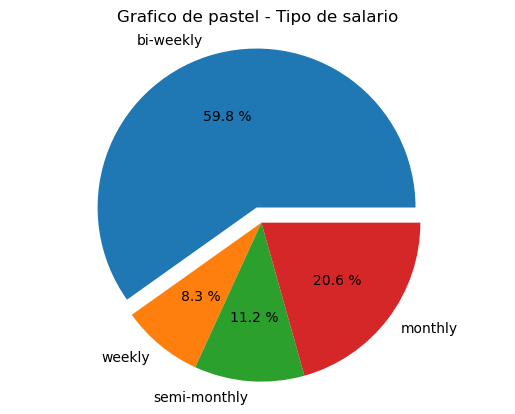

In [9]:
desfase = (0.1, 0, 0, 0)
plt.pie(frecuencias_tipo_de_salario, labels=df.Tipo_de_salario.unique(), autopct="%0.1f %%", explode=desfase)
plt.title('Grafico de pastel - Tipo de salario')
plt.axis("equal")
plt.show()

En base a lo observado se tiene en cuenta que:
* El 59.8% de las personas le pagan quincenalmente.
* El 20.6% de las personas le pagan mensualmente.
* El 11.2% de las personas le pagan cada 3 semanas.
* El 8.3% de las personas le pagan cada semana.

### Columna Vivienda propia

In [10]:
df.Vivienda_propia.groupby(by=df.Vivienda_propia).count()

Vivienda_propia
0    10294
1     7614
Name: Vivienda_propia, dtype: int64

C:\Users\Ismael\AppData\Local\Temp\ipykernel_3712\313313223.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temporal['Etiquetado'] = arreglo_etiquetado


[Text(0.5, 1.0, 'Personas con vivienda propia'),
 Text(0.5, 0, 'Vivienda propia'),
 Text(0, 0.5, 'Cantidad de personas')]

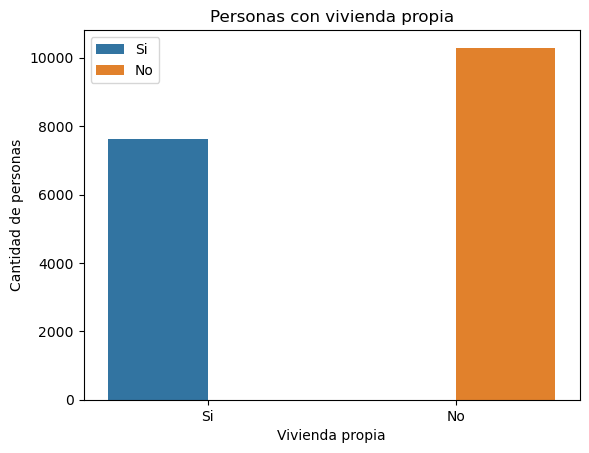

In [11]:
df_temporal = df.loc[:,'Vivienda_propia'] 
arreglo_etiquetado.clear()
df_temporal.apply(convertir_etiquetas_binarias)
df_temporal['Etiquetado'] = arreglo_etiquetado
sns.countplot(data=df_temporal, x='Etiquetado', hue='Etiquetado').set(title="Personas con vivienda propia", xlabel="Vivienda propia", ylabel='Cantidad de personas')

En base a lo observado se concluye que:
* 10294 personas no cuentan con vivienda propia 
* 7614 personas cuentan con vivienda propia

### Columna Ingreso 

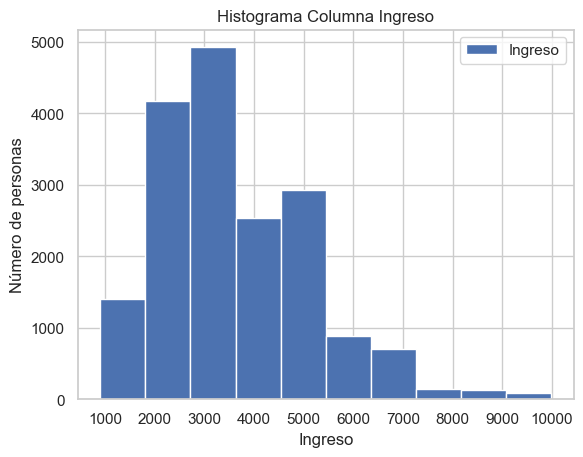

In [12]:
sns.set_theme(style="whitegrid")
bins = range(1000,11000,1000)
nombre_columna_grafico = "Ingreso"
plt.hist(x=df[nombre_columna_grafico].values, histtype="bar", label=nombre_columna_grafico, align="mid", rwidth=None)
titulo_grafico = 'Histograma Columna ' + nombre_columna_grafico
plt.title(titulo_grafico)
plt.xlabel(nombre_columna_grafico)
plt.ylabel('Número de personas')
plt.xticks(bins)
plt.legend()
plt.show()

De acuerdo a lo observado se puede llegar a la conclusión que:
* 1400 personas ganan entre 1000-2000 USD
* 4100 personas ganan entre 2000-3000 USD
* 4900 personas ganan entre 3000-4000 USD
* 2600 personas ganan entre 4000-5000 USD
* 2900 personas ganan entre 5000-6000 USD
* 800 personas ganan entre 6000-7000 USD
* 100 personas ganan entre 7000-8000 USD
* 100 personas ganan entre 8000-9000 USD
* 80 personas ganan entre 9000-10000 USD 

### Columna Tiempo_trabajado en meses

[Text(0.5, 1.0, 'Distribución de frecuencia - Tiempo trabajado en meses'),
 Text(0.5, 0, 'Tiempo_trabajado(meses)'),
 Text(0, 0.5, 'Cantidad de personas')]

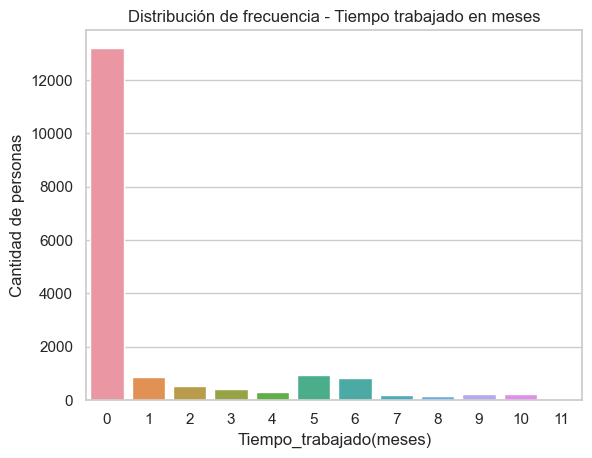

In [13]:
nombre_columna_grafico = "Tiempo_trabajado(meses)"
titulo_grafico = "Distribución de frecuencia - Tiempo trabajado en meses"
sns.countplot(data=df, x=nombre_columna_grafico).set(title=titulo_grafico, xlabel=nombre_columna_grafico, ylabel='Cantidad de personas')

Por lo que se puede visualizar se puede notar que:
* 14000 personas no han trabajado ningun mes (completo).
* 900 personas han trabajado 1 mes.
* 500 personas han trabajado 2 meses.
* 400 personas han trabajado 3 meses.
* 300 personas han trabajado 4 meses.
* 1000 personas han trabajado 5 meses.
* 900 personas han trabajado 6 meses.
* 100 personas han trabajado 7 meses.
* 100 personas han trabajado 8 meses.
* 200 personas han trabajado 9 meses.
* 200 personas han trabajado 10 meses.
* menos de 100 personas han trabajado 11 meses.

### Columna Tiempo trabajado en años

[Text(0.5, 1.0, 'Distribución de frecuencia - Tiempo trabajado en años'),
 Text(0.5, 0, 'Tiempo_trabajado(anos)'),
 Text(0, 0.5, 'Cantidad de personas')]

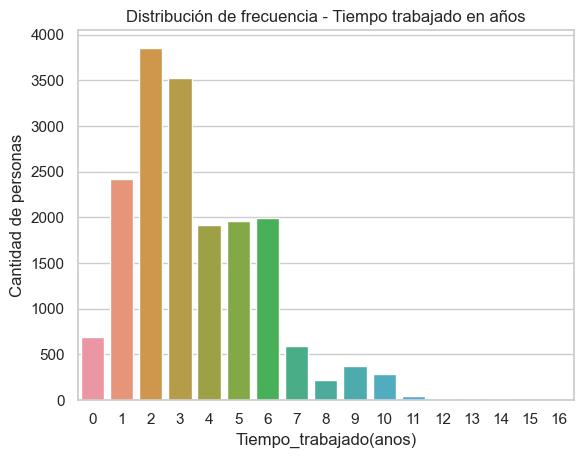

In [14]:
nombre_columna_grafico = "Tiempo_trabajado(anos)"
titulo_grafico = "Distribución de frecuencia - Tiempo trabajado en años"
sns.countplot(data=df, x=nombre_columna_grafico).set(title=titulo_grafico, xlabel=nombre_columna_grafico, ylabel='Cantidad de personas')

En base a esta grafica se puede ver que aproximadamente que:
* 700 personas no han trabajado 1 año (completo).
* 2400 personas han trabajado 1 año.
* 3800 personas han trabajado 2 años.
* 3500 personas han trabajado 3 años.
* 1800 personas han trabajado 4 años.
* 1900 personas han trabajado 5 años.
* 2000 personas han trabajado 6 años.
* 600 personas han trabajado 7 años.
* 200 personas han trabajado 8 años.
* 300 personas han trabajado 9 años.
* 400 personas han trabajado 10 años.
* menos de 100 personas han trabajado 11 años.
* Hay minimas personas que han trabajado entre 12-16 años.

### Columna Tiempo en su vivienda actual, medido en años

[Text(0.5, 1.0, 'Distribución de frecuencia - Tiempo en vivienda actual en años'),
 Text(0.5, 0, 'Tiempo_en_vivienda_actual(anos)'),
 Text(0, 0.5, 'Cantidad de personas')]

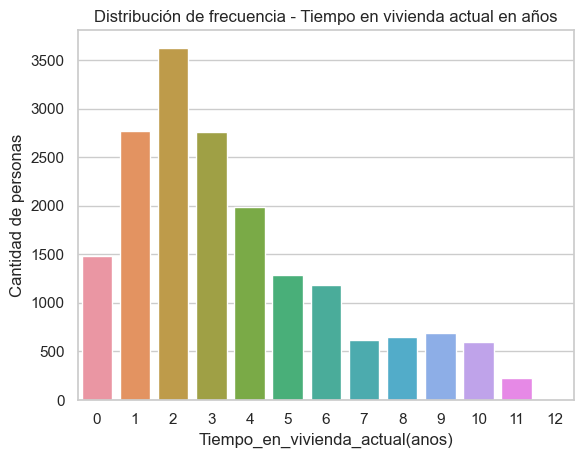

In [15]:
nombre_columna_grafico = "Tiempo_en_vivienda_actual(anos)"
titulo_grafico = "Distribución de frecuencia - Tiempo en vivienda actual en años"
sns.countplot(data=df, x=nombre_columna_grafico).set(title=titulo_grafico, xlabel=nombre_columna_grafico, ylabel='Cantidad de personas')

Visualizando este grafico se llega a la conclusión de:
* 1400 personas no han cumplido un año en su vivienda actual.
* 2700 personas han estado en su vivienda 1 años.
* 3600 personas han estado en su vivienda 2 años.
* 2700 personas han estado en su vivienda 3 años.
* 2000 personas han estado en su vivienda 4 años.
* 1300 personas han estado en su vivienda 5 años.
* 1200 personas han estado en su vivienda 6 años.
* 600 personas han estado en su vivienda 7 años.
* 700 personas han estado en su vivienda 8 años.
* 700 personas han estado en su vivienda 9 años.
* 600 personas han estado en su vivienda 10 años.
* 200 personas han estado en su vivienda 11 años.
* menos de 100 personas han estado en su vivienda 12 años.

### Columna Tiempo con su cuenta personal, medido en meses

[Text(0.5, 1.0, 'Distribución de frecuencia - Tiempo con su cuenta personal en meses'),
 Text(0.5, 0, 'Tiempo_cuenta_personal(meses)'),
 Text(0, 0.5, 'Cantidad de personas')]

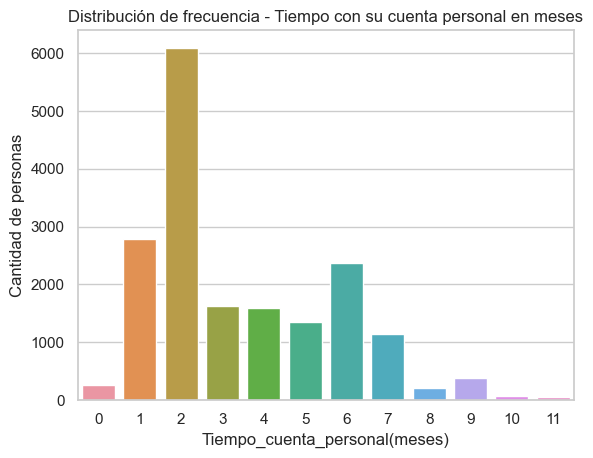

In [16]:
nombre_columna_grafico = "Tiempo_cuenta_personal(meses)"
titulo_grafico = "Distribución de frecuencia - Tiempo con su cuenta personal en meses"
sns.countplot(data=df, x=nombre_columna_grafico).set(title=titulo_grafico, xlabel=nombre_columna_grafico, ylabel='Cantidad de personas')

Visualizando la grafica se puede apreciar que: 
* 200 personas no tienen ningun mes (completos) con su cuenta personal.
* 2800 personas tienen 1 mes con su cuenta personal.
* 6000 personas tienen 2 meses con su cuenta personal.
* 1600 personas tienen 3 meses con su cuenta personal.
* 1600 personas tienen 4 meses con su cuenta personal.
* 1300 personas tienen 5 meses con su cuenta personal.
* 2300 personas tienen 6 meses con su cuenta personal.
* 1100 pérsonas tienen 7 meses con su cuenta personal.
* 200 personas tienen 8 meses con su cuenta personal. 
* 400 personas tienen 9 meses con su cuenta personal.
* menos de 100 tienen 10 u 11 meses con su cuenta personal.

### Columna Tiempo con su cuenta personal, medido en años

[Text(0.5, 1.0, 'Distribución de frecuencia - Tiempo con su cuenta personal en años'),
 Text(0.5, 0, 'Tiempo_cuenta_personal(anos)'),
 Text(0, 0.5, 'Cantidad de personas')]

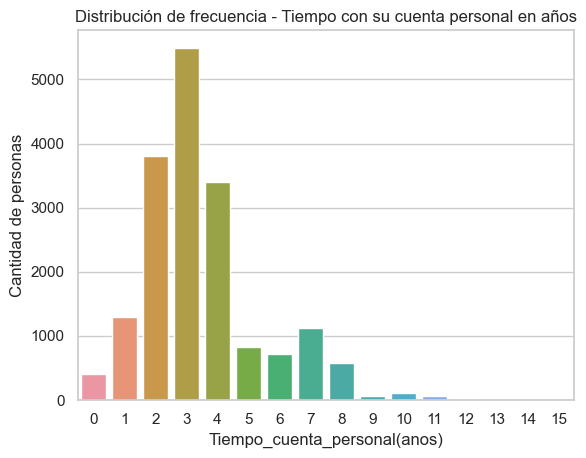

In [17]:
nombre_columna_grafico = "Tiempo_cuenta_personal(anos)"
titulo_grafico = "Distribución de frecuencia - Tiempo con su cuenta personal en años"
sns.countplot(data=df, x=nombre_columna_grafico).set(title=titulo_grafico, xlabel=nombre_columna_grafico, ylabel='Cantidad de personas')

Vista la grafica previa se puede demostrar que:
* 400 personas no tienen un año (completo) con su cuenta personal.
* 1200 personas tienen 1 año con su cuenta personal.
* 3800 personas tienen 2 años con su cuenta personal.
* 5500 personas tienen 3 años con su cuenta personal.
* 3400 personas tienen 4 años con su cuenta personal. 
* 800 personas tienen 5 años con su cuenta personal.
* 700 personas tienen 6 años con su cuenta personal.
* 1100 personas tienen 7 años con su cuenta personal.
* 500 personas tienen 8 años con su cuenta personal.
* 100 y menos de 100 personas tienen 9 a 15 años con su cuenta personal.

### Columna Adeudos

C:\Users\Ismael\AppData\Local\Temp\ipykernel_3712\160908769.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temporal['Etiquetado'] = arreglo_etiquetado


[Text(0.5, 1.0, 'Distribución de frecuencia - Adeudos'),
 Text(0.5, 0, 'Adeudos'),
 Text(0, 0.5, 'Cantidad de personas')]

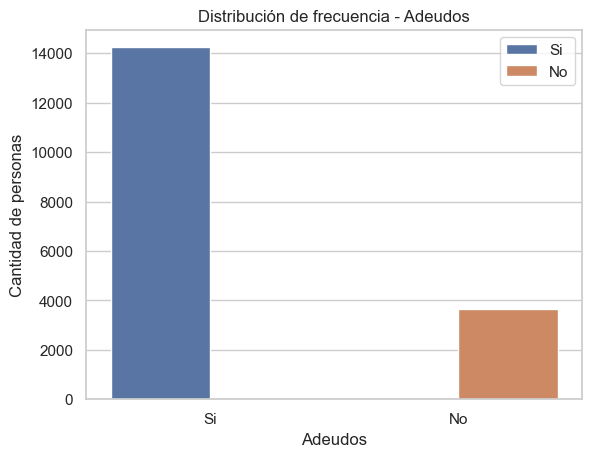

In [18]:
nombre_columna_grafico = "Adeudos"
titulo_grafico = "Distribución de frecuencia - Adeudos"
df_temporal = df.loc[:,'Adeudos'] 
arreglo_etiquetado.clear()
df_temporal.apply(convertir_etiquetas_binarias)
df_temporal['Etiquetado'] = arreglo_etiquetado
sns.countplot(data=df_temporal, x='Etiquetado', hue='Etiquetado').set(title=titulo_grafico, xlabel=nombre_columna_grafico, ylabel='Cantidad de personas')

Viendo la grafica anterior se puede demostrar que:
* 14000 personas si tienen adeudos
* 3800 personas no tienen adeudos.

### Columna Cantidad solicitada

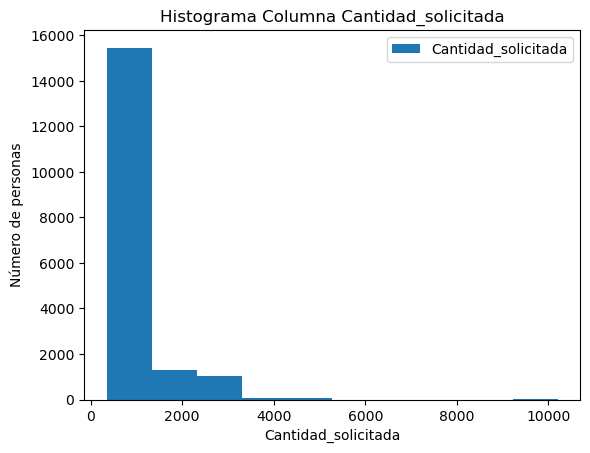

In [19]:
plt.rcdefaults()
#bins = range(1000,11000,1000)
nombre_columna_grafico = "Cantidad_solicitada"
plt.hist(x=df[nombre_columna_grafico].values, histtype="bar", label=nombre_columna_grafico, align="mid", rwidth=None)
titulo_grafico = 'Histograma Columna ' + nombre_columna_grafico
plt.title(titulo_grafico)
plt.xlabel(nombre_columna_grafico)
plt.ylabel('Número de personas')
#plt.xticks(bins)
plt.legend()
plt.show()

Despues de ver la grafica se puede visualizar que:
* 15500 personas solicitaron entre 0-1500 USD.
* 1000 personas solicitaron entre 1500-2300 USD.
* 900 personas solicitaron entre 2300-3200 USD.
* 100 o menos de 100 personas solicitaron entre 3100-10500 USD.

### Columna Puntuación de riesgo

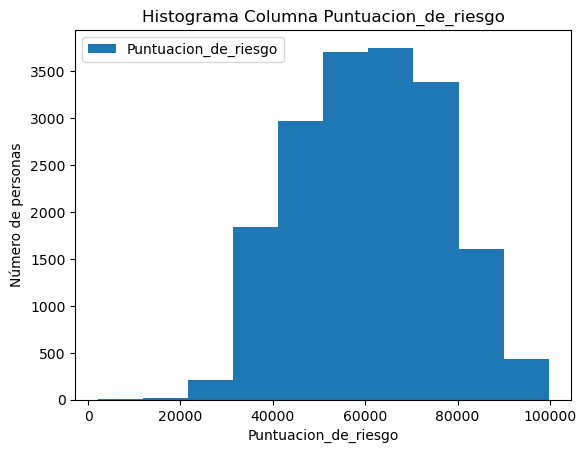

In [20]:
#bins = range(1000,11000,1000)
nombre_columna_grafico = "Puntuacion_de_riesgo"
plt.hist(x=df[nombre_columna_grafico].values, histtype="bar", label=nombre_columna_grafico, align="mid", rwidth=None)
titulo_grafico = 'Histograma Columna ' + nombre_columna_grafico
plt.title(titulo_grafico)
plt.xlabel(nombre_columna_grafico)
plt.ylabel('Número de personas')
#plt.xticks(bins)
plt.legend()
plt.show()

Visto lo anterior se puede demostrar que: 
* Menos de 100 personas han tenido una puntacion de riesgo entre 0 y 25000
* 200 personas han tenido una puntuacion de riesgo entre 25000 y 32000
* 1700 personas han tenido una puntuacion de riesgo entre 32000 y 40000
* 3000 personas han tenido una puntuacion de riesgo entre  40000 y 50000
* 3600 personas han tenido una puntuacion de riesgo entre 50000 y 60000
* 3700 personas han tenido una puntuacion de riesgo entre 60000 y 70000
* 3300 perosnas han tenido una puntuacion de riesgo entre 70000 y 80000
* 1600 personas han tenido una puntuacion de riesgo entre 80000 y 90000
* 400 personas han tenido una puntuacion de riesgo entre 90000 y 100000




### Columna Puntuación de riesgo 2

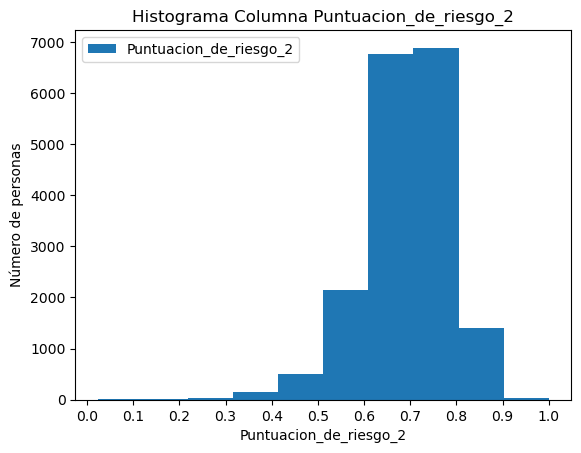

In [21]:
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
nombre_columna_grafico = "Puntuacion_de_riesgo_2"
plt.hist(x=df[nombre_columna_grafico].values, histtype="bar", label=nombre_columna_grafico, align="mid", rwidth=None)
titulo_grafico = 'Histograma Columna ' + nombre_columna_grafico
plt.title(titulo_grafico)
plt.xlabel(nombre_columna_grafico)
plt.ylabel('Número de personas')
plt.xticks(bins)
plt.legend()
plt.show()

Mediante esta grafica se puede verificar que:
* 100 y menos de 100 personas tienen entre 0.0 y 0.42 de puntuacion de riesgo
* 500 personas tienen entre .42 y 0.51 de puntuacion de riesgo
* 2300 personas tienen entre 0.51 y 0.61 de puntuacion de riesgo
* 6800 personas tienen entre 0.61 y 0.7 de puntuacion de riesgo
* 7000 personas tienen entre 0.7 y 0.8 de puntuacion de riesgo
* 1200 personas tienen entre 0.8 y 0.9 de puntuacion de riesgo
* menos de 100 personas tienen entre 0.9 y 1 de puntuacion de riesgo  

### Columna Puntuación de riesgo 3

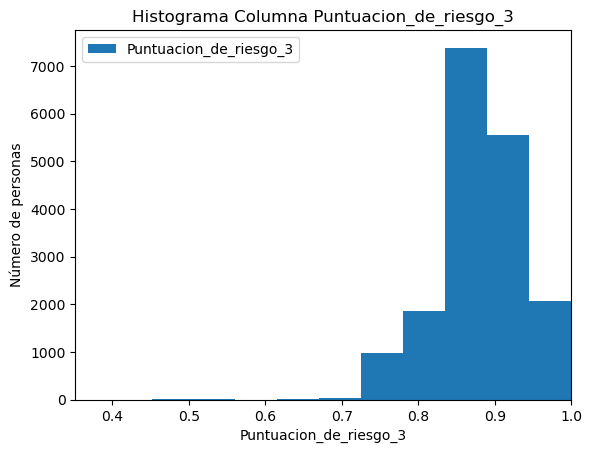

In [22]:
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
nombre_columna_grafico = "Puntuacion_de_riesgo_3"
plt.hist(x=df[nombre_columna_grafico].values, histtype="bar", label=nombre_columna_grafico, align="mid", rwidth=None)
titulo_grafico = 'Histograma Columna ' + nombre_columna_grafico
plt.title(titulo_grafico)
plt.xlabel(nombre_columna_grafico)
plt.ylabel('Número de personas')
plt.xticks(bins)
plt.xlim(df[nombre_columna_grafico].min()-.1,df[nombre_columna_grafico].max()+.001)
plt.legend()
plt.show()

Se puede visualizar que:
* menos de 100 personas tienen una puntuacion de riesgo entre 0.4 y 0.74
* 1000 personas tienen una puntuacion de riesgo entre 0.74 y 0.79
* 2000 personas tienen una puntuacion de riesgo entre 0.79 y 0.84
* 7300 personas tienen una puntuacion de riesgo entre 0.84 y 0.9
* 2000 personas tienen una puntuacion de riesgo entre 0.9 y 1.0


### Columna Puntuación de riesgo 4

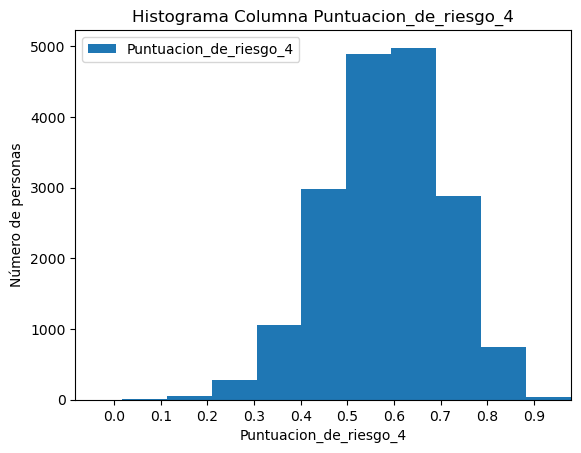

In [23]:
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
nombre_columna_grafico = "Puntuacion_de_riesgo_4"
plt.hist(x=df[nombre_columna_grafico].values, histtype="bar", label=nombre_columna_grafico, align="mid", rwidth=None)
titulo_grafico = 'Histograma Columna ' + nombre_columna_grafico
plt.title(titulo_grafico)
plt.xlabel(nombre_columna_grafico)
plt.ylabel('Número de personas')
plt.xticks(bins)
plt.xlim(df[nombre_columna_grafico].min()-.1,df[nombre_columna_grafico].max()+.001)
plt.legend()
plt.show()

Se puede demostrar que:
* Menos de 100 personas tienen una puntaucion de riesgo entre 0.0 y 0.21
* 300 personas tienen una puntuacion de riesgo entre 0.21 y 0.31
* 1000 personas tienen una puntuacion de riesgo entre 0.31 y 0.4
* 3000 personas tienen una puntuacion de riesgo entre 0.4 y 0.5
* 4900 personas tienen una puntuacion de riesgo entre 0.5 y 0.6
* 5000 personas tienen una puntuacion de riesgo entre 0.6 y 0.7
* 2900 personas tienen una puntuacion de riesgo entre 0.7 y 0.78
* 700 personas tienen una puntuacion de riesgo entre 0.78 y 0.88
* Menos de 100 personas tienen un apuntuacion de riesgo entre 0.88 y 0.99
 

### Columna Puntuación de riesgo 5

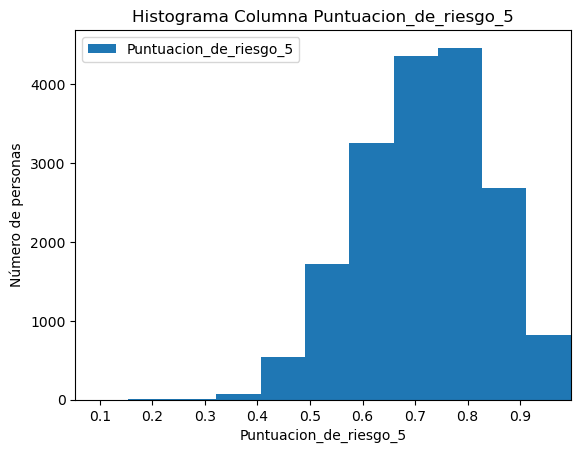

In [24]:
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
nombre_columna_grafico = "Puntuacion_de_riesgo_5"
plt.hist(x=df[nombre_columna_grafico].values, histtype="bar", label=nombre_columna_grafico, align="mid", rwidth=None)
titulo_grafico = 'Histograma Columna ' + nombre_columna_grafico
plt.title(titulo_grafico)
plt.xlabel(nombre_columna_grafico)
plt.ylabel('Número de personas')
plt.xticks(bins)
plt.xlim(df[nombre_columna_grafico].min()-.1,df[nombre_columna_grafico].max()+.001)
plt.legend()
plt.show()

Se puede visualizar que:
* 100 o menos de 100 personas tienen una puntuacion de riesgo entre 0.1 y 0.41
* 600 personas tienen una puntuacion de riesgo entre 0.41 y 0.5
* 1600 personas tienen una puntuacion de riesgo entre 0.5 y 0.58
* 3100 personas tienen una puntuacion de riesgo entre 0.58 y 0.67
* 4300 personas tienen una puntuacion de riesgo entre 0.67 y 0.75
* 4400 personas tienen una puntuacion de riesgo entre 0.75 y 0.83
* 2600 personas tienen una puntuacion de riesgo entre 0.83 y 0.91
* 700 personas tienen una puntuaciond de riesgo entre 0.91 y 1.0

### Columna ext_quality score

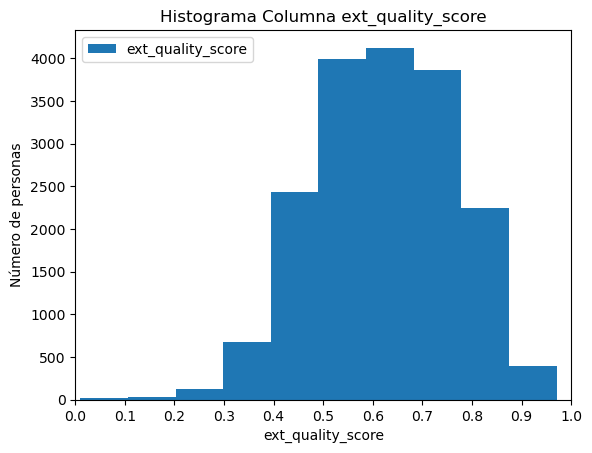

In [25]:
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
nombre_columna_grafico = "ext_quality_score"
plt.hist(x=df[nombre_columna_grafico].values, histtype="bar", label=nombre_columna_grafico, align="mid", rwidth=None)
titulo_grafico = 'Histograma Columna ' + nombre_columna_grafico
plt.title(titulo_grafico)
plt.xlabel(nombre_columna_grafico)
plt.ylabel('Número de personas')
plt.xticks(bins)
plt.xlim(0,1)
plt.legend()
plt.show()

Se puede visualizar que:
* 100 y menos de 100 personas tienen una puntuacion de riesgo externa entre 0.0 y 0.3
* 700 personas tienen una puntuacion de riesgo externa entre 0.3 y 0.4
* 2500 personas tienen una puntuacion de riesgo externa entre 0.4 y 0.5
* 3900 personas tienen una puntuacion de riesgo externa entre 0.5 0.6
* 4000 personas tienen una puntuacion de riesgo externa entre 0.6 y 0.68
* 3700 personsas tienen una puntuacion de riesgo externa entre 0.68 y 0.78
* 2300 personas tienen una puntuacion de riesgo externa entre 0.78 y 0.87
* 400 personas tienen una puntuacion de riesgo externa entre 0.87 y 9.8
 

### Columna ext_quality score 2

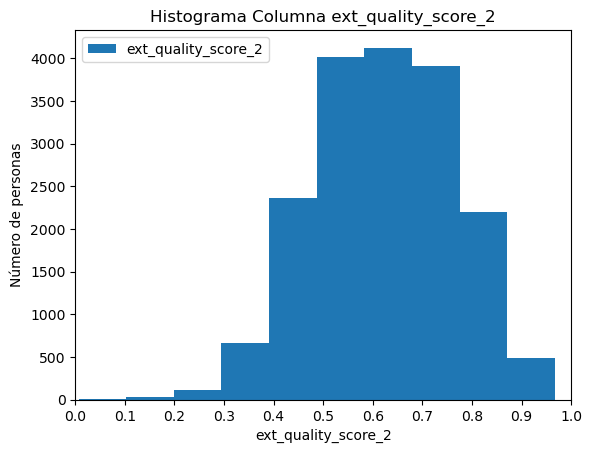

In [26]:
ins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
nombre_columna_grafico = "ext_quality_score_2"
plt.hist(x=df[nombre_columna_grafico].values, histtype="bar", label=nombre_columna_grafico, align="mid", rwidth=None)
titulo_grafico = 'Histograma Columna ' + nombre_columna_grafico
plt.title(titulo_grafico)
plt.xlabel(nombre_columna_grafico)
plt.ylabel('Número de personas')
plt.xticks(bins)
plt.xlim(0,1)
plt.legend()
plt.show()

Se puede visualizar que:
* 100 y menos de 100 personas tienen una puntuacion de riesgo externa entre 0.0 y 0.3
* 700 personas tienen una puntuacion de riesgo externa entre 0.3 y 0.4 
* 2400 personas tienen una puntuacion de riesgo externa entre 0.4 y 0.5
* 4000 personas tienen una puntuacion de riesgo externa entre 0.5 y 0.6
* 4100 personas tienen una puntuacion de riesgo externa entre 0.6 y 0.7
* 3900 personas tienen una puntuacion de riesgo externa entre 0.7 y 0.78
* 2300 personas tienen una puntuacion de riesgo externa entre 0.78 y 0.88
* 500 personas tienen una puntuacion de reisgo externa entre 0.88 y 0.98
 

### Columna Consultas realizadas el mes pasado

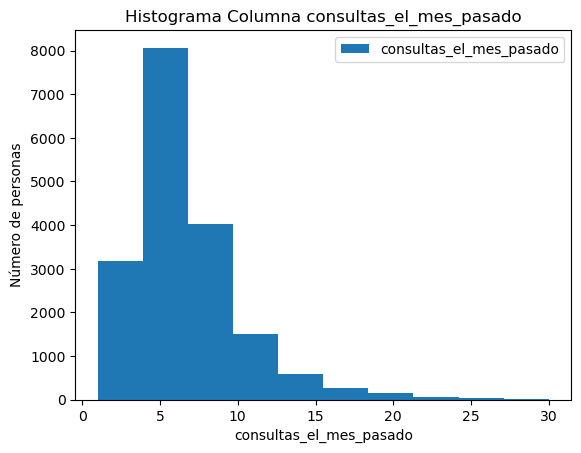

In [27]:
#bins = range(1000,11000,1000)
nombre_columna_grafico = "consultas_el_mes_pasado"
plt.hist(x=df[nombre_columna_grafico].values, histtype="bar", label=nombre_columna_grafico, align="mid", rwidth=None)
titulo_grafico = 'Histograma Columna ' + nombre_columna_grafico
plt.title(titulo_grafico)
plt.xlabel(nombre_columna_grafico)
plt.ylabel('Número de personas')
#plt.xticks(bins)
plt.legend()
plt.show()

Se puede visualizar que:
* 3100 personas tienen entre 0 y 4 consultas el mes pasado
* 8000 personas tienen entre 4 y 7 consultas el mes pasado
* 4000 personas tienen entre 7 y 9 consultas el mes pasado
* 1500 personas tienen entre 9 y 13 consultas el mes pasado
* 500 personas tienen entre 13 y 16 consultas el mes pasado
* 100 y menos de 100 personas tienen entre 16 y 30 consultas el mes pasado

### Columna Proceso de firma electronica

C:\Users\Ismael\AppData\Local\Temp\ipykernel_3712\3797218746.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temporal['Etiquetado'] = arreglo_etiquetado


[Text(0.5, 1.0, 'Distribución de frecuencia - Firma Electronica'),
 Text(0.5, 0, 'Proceso_firma_electronica_completado'),
 Text(0, 0.5, 'Cantidad de personas')]

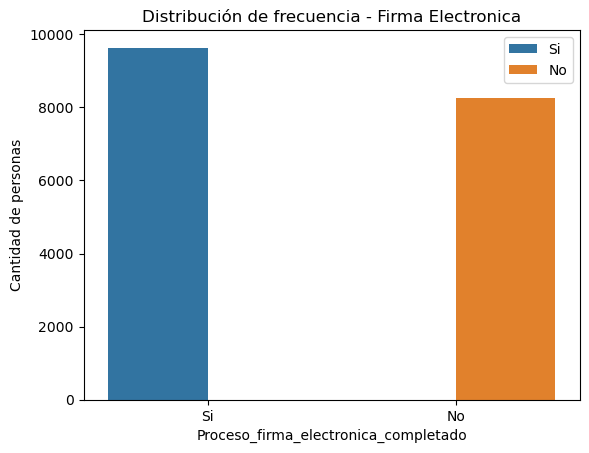

In [28]:
nombre_columna_grafico = "Proceso_firma_electronica_completado"
titulo_grafico = "Distribución de frecuencia - Firma Electronica"
df_temporal = df.loc[:,'Proceso_firma_electronica_completado'] 
arreglo_etiquetado.clear()
df_temporal.apply(convertir_etiquetas_binarias)
df_temporal['Etiquetado'] = arreglo_etiquetado
sns.countplot(data=df_temporal, x='Etiquetado', hue='Etiquetado').set(title=titulo_grafico, xlabel=nombre_columna_grafico, ylabel='Cantidad de personas')

Se puede visualizar que:
* 9500 personas han realizado su proceso de firma electronica
* 8000 personas no han realizado su proceso de firma electronica

### Dimensionando los datos
Se puede observar mediante la función shape que se tiene en el dataset un total de 20 columnas, con un total de mas de 17908 registros en ellos.

In [29]:
df.shape

(17908, 20)

### Tipos de datos
Para saber que tipo de datos es la que tiene cada una de las columnas aplicamos el método dtypes.

In [30]:
df.dtypes

Edad                                      int64
Tipo_de_salario                          object
Vivienda_propia                           int64
Ingreso                                   int64
Tiempo_trabajado(meses)                   int64
Tiempo_trabajado(anos)                    int64
Tiempo_en_vivienda_actual(anos)           int64
Tiempo_cuenta_personal(meses)             int64
Tiempo_cuenta_personal(anos)              int64
Adeudos                                   int64
Cantidad_solicitada                       int64
Puntuacion_de_riesgo                      int64
Puntuacion_de_riesgo_2                  float64
Puntuacion_de_riesgo_3                  float64
Puntuacion_de_riesgo_4                  float64
Puntuacion_de_riesgo_5                  float64
ext_quality_score                       float64
ext_quality_score_2                     float64
consultas_el_mes_pasado                   int64
Proceso_firma_electronica_completado      int64
dtype: object

Para explicar cada columna tenemos lo siguiente:

Edad: Tipo Int ya que solo se toman numeros enteros para las edades, no hay mitad de una edad.

Tipo_De_Salario: Es de tipo objeto, sin embargo, se convertira a tipo numerico entero, ya que es columna categorica, usando 1,2,3,4.

Vivienda_propia: Tipo entero, ya que se tienen 3 opciones, prestada, rentada, propia, los cuales se visualizan con los numeros 1, 2 y 3

Ingreso: Se utiliza tipo entero, ya que aunque puede haber salarios con punto decimal, no afectan finalmente al salario de cada individuo, por lo que se requiere solo de el salario en numero entero.

Tiempo_Trabajando(meses): Se usa porque solo se requiere saber la cantidad de meses que se ha trabajado, numeros del 1 al 12 sin decimales.
Tiempo_trabajado(anos): Se requiere saber la cantidad de años trabajados, sin embargo no interesan los decimales, pues 1 año y medio sigue siendo un año trabajado solamente.

Tiempo_en_vivienda_actual(anos): De igual forma en enteros, ya que interesa saber la cantidad de años que se ha vivido en la casa donde se encuentra actualmente.

Tiempo_cuenta_personal(meses): Cantidad de tiempo en meses desde que se abrio la cuenta personal, no interesan las semanas extra, solo los meses exactos.
Tiempo_cuenta_personal(Anos): Cantidad de tiempo en años desde que se abrio la cuenta personal, no interesan las meses extra, solo los años exactos.

Adeudos: Es de tipo entero, ya que se requiere saber si tiene o no alguna deuda, por lo que se usara si o no (1 o 0).

Cantidad_solicitada: Solamente se realizaran prestamos en numeros cerrados, no en numeros con punto decimal, 10k si, 10,250.55 no.

Puntuacion_de_riesgo:       -Estos datos ya estaban entrenados en el Dataset original
Puntuacion_de_riesgo_2:     -Estos datos ya estaban entrenados en el Dataset original           
Puntuacion_de_riesgo_3:     -Estos datos ya estaban entrenados en el Dataset original            
Puntuacion_de_riesgo_4:     -Estos datos ya estaban entrenados en el Dataset original            
Puntuacion_de_riesgo_5:     -Estos datos ya estaban entrenados en el Dataset original

ext_quality_score:          -Estos datos ya estaban entrenados en el Dataset original
ext_quality_score_2:        -Estos datos ya estaban entrenados en el Dataset original

consultas_el_mes_pasado: Enteros, ya que se requiere saber cuantas veces realizo consultas de su saldo durante el mes, y no existen medias consultas.

Proceso_firma_electronica_completado: Numerico entero, ya que se requiere saber si se completo o no el proceso, usando el 1 y 0, para completado o no.

## Descripción estadística
Mediante el uso de un describe podremos ver la informacion de los datos numericos estadisticos (Conteo, Media, Desviación estandar, Minimos, Maximos, y los cuartiles por defecto [25, 50, 75]).

Se presenta primeramente para los datos de tipo númerico

In [31]:
df.describe()

,Edad,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
count,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000
mean,43.015412,0.425173,3657.214653,1.186006,3.526860,3.584711,3.427183,3.503350,0.795399,950.446449,61086.302211,0.690878,0.878276,0.583155,0.718252,0.623112,0.622068,6.457226,0.538251
std,11.873107,0.494383,1504.890063,2.400897,2.259732,2.751937,2.216440,1.955568,0.403421,698.543683,15394.255020,0.090470,0.054563,0.125061,0.120697,0.139729,0.139898,3.673093,0.498549
min,18.000000,0.000000,905.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,350.000000,2100.000000,0.023258,0.451371,0.016724,0.153367,0.010184,0.006622,1.000000,0.000000
25%,34.000000,0.000000,2580.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,600.000000,49350.000000,0.640993,0.850882,0.500208,0.633708,0.521735,0.519677,4.000000,0.000000
50%,42.000000,0.000000,3260.000000,0.000000,3.000000,3.000000,2.000000,3.000000,1.000000,700.000000,61200.000000,0.699561,0.881004,0.588208,0.725113,0.625944,0.622973,6.000000,1.000000
75%,51.000000,1.000000,4670.000000,1.000000,5.000000,5.000000,5.000000,4.000000,1.000000,1100.000000,72750.000000,0.752887,0.912608,0.672395,0.806681,0.729841,0.728940,8.000000,1.000000
max,96.000000,1.000000,9985.000000,11.000000,16.000000,12.000000,11.000000,15.000000,1.000000,10200.000000,99750.000000,0.999997,0.999024,0.978932,0.996260,0.970249,0.966953,30.000000,1.000000


In [32]:
df[(df['Ingreso']<=6760) & (df['Ingreso']>=490)]

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,40,bi-weekly,1,3135,0,3,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,61,weekly,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,23,weekly,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,40,bi-weekly,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,33,semi-monthly,0,3590,0,5,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17903,31,monthly,0,3245,0,5,3,2,6,1,700,71700,0.691126,0.928196,0.664112,0.838012,0.727705,0.627705,2,0
17904,46,bi-weekly,0,6525,0,2,1,3,3,1,800,51800,0.648525,0.970832,0.699241,0.844724,0.774918,0.474918,3,0
17905,46,weekly,0,2685,0,5,1,1,8,1,1200,59650,0.677975,0.918141,0.687981,0.939101,0.472045,0.672045,9,0
17906,42,bi-weekly,0,2515,0,3,5,6,1,1,400,80200,0.642741,0.885684,0.456448,0.686823,0.406568,0.406568,3,1


### Explicacion del describe del dataframe

count: Permite ver la cantidad total de filas de datos que hay en el dataset.

mean: permite ver la media de cada una de las columnas, por ejemplo, la cantidad media de la columna edad seria 43.015412, mientras que la media de años trabajados seria de 3.526860.

std: permite ver el valor de la desviacion estandar calculado de cada columna.

min: Permite ver el dato con el valor minimo de cada columna, por ejemplo, la edad de la persona o personas mas joven en la lista es de 18 años.

25%: Primer Cuartil, muestra el valor sobre el que la primera cuarta parte de los datos se encuentran, por ejemplo edad, el 25% de las personas tienen 34 años o menos.

50%: Segundo Cuartil, muestra el valor sobre el que se encuentra la segunda cuarta parte de los datos, coincide con la mediana de los datos.

75%: Tercer Cuartil, muestra el valor sobre el que se encuentra la tercera cuarta parte de los datos, por ejemplo en edad, el 75% de las personas tienen 51 años o menos.

max: Muestra el dato con el valor maximo de cada columna, ejemplo, edad la persona con mayor edad es de 96 años.

Y para los datos de tipo texto

In [33]:
df.describe(include=[object])

,Tipo_de_salario
count,17908
unique,4
top,bi-weekly
freq,10716


Como podemos observar, la columna salario maneja solamente 4 valores unicos dentro de la columna, asi que la información manejada es de tipo categorica. La frecuencia de su top, que es bi-weekly, o en español quincenal, es de 10716 registros, por lo que aproximadamente el **60%** del dataset incluyo personas que realizaron el proceso de firma electronica, que en sus trabajos su pago es quincenal. 

### Distribución de clases

Observamos como se distribuyen los datos de la columna independiente(objetivo).

In [34]:
conteo_df = df.groupby("Proceso_firma_electronica_completado").size()
conteo_df

Proceso_firma_electronica_completado
0    8269
1    9639
dtype: int64

Observamos que los datos recopilados en el dataset nos muestra que contiene el **46%** de personas que no completaron el proceso, mientras que el **54%** si lo completo.

Podemos decir que los datos se encuentran balanceados, asi que no tendremos problemas para confiar en la precisión de nuestro clasificador.

## Preprocesamiento 

### Datos faltantes

Como podemos observar en la siguiente instrucción, nos realiza una busqueda indicando si alguna columna presenta valores nulos. 

In [35]:
df.isnull().any()

Edad                                    False
Tipo_de_salario                         False
Vivienda_propia                         False
Ingreso                                 False
Tiempo_trabajado(meses)                 False
Tiempo_trabajado(anos)                  False
Tiempo_en_vivienda_actual(anos)         False
Tiempo_cuenta_personal(meses)           False
Tiempo_cuenta_personal(anos)            False
Adeudos                                 False
Cantidad_solicitada                     False
Puntuacion_de_riesgo                    False
Puntuacion_de_riesgo_2                  False
Puntuacion_de_riesgo_3                  False
Puntuacion_de_riesgo_4                  False
Puntuacion_de_riesgo_5                  False
ext_quality_score                       False
ext_quality_score_2                     False
consultas_el_mes_pasado                 False
Proceso_firma_electronica_completado    False
dtype: bool

Se puede ver que todas retornan un falso, es decir, el dataframe no presenta datos con campos vacios, por lo que no es necesario realizar ninguna operación de rellenado. Por lo que unicamente nos limitarermos a explicar como utilizariamos los métodos en caso de que hubiera presentado la situación.


#### Rellenado de datos con el valor 0.
Esto es recomendable con valores categoricos, ya que el etiquetado permitiria lidiar con el manejo de los datos sin necesidad de modificar los resultados posteriormente aplicando un clasificador, etc.

Suponiendo que nuestro dataset hubiera presentado valores faltantes, especificamente en nuestra columna "Tipo_de_salario", que muestra cada cuanto tiempo recibe su pago en su trabajo....


In [36]:
df.Tipo_de_salario.unique()

array(['bi-weekly', 'weekly', 'semi-monthly', 'monthly'], dtype=object)

como observamos no cuenta con una etiqueta que indique que se desconoce el dato sobre una persona, por lo que si un dato se encontrara vacio, creariamos precisamente esa nueva etiqueta sobre los datos nulos, en codigo quedaria así:

`
df.Tipo_de_salario.fillna('Unknown', inplace=True) 
`

##### ¿Donde no es recomendado?
No se recomienda por ninguna razón aplicar este método en columnas de salida donde ya se ah entrenado el dataset previamente, esto afecta significativamente la precisión del algoritmo al introducir resultados falsos a una columna de salida, con variables independientes que desconocemos si cumplen la condición.

#### Rellenado de datos con estadisticos (media, mediana y moda)

Esto se aplicaria exclusivamente a columnas que manejan datos de tipo númerico, y en nuestra opinión, consideramos que la mejor opción a utilizar la mediana, ya que rellena con valores que se verian poco afectados por los datos atipicos de las columnas, sin embargo se podria utilizar cualquiera de ellas en teoria.

Dejamos un código de ejemplo aquí que nosotros escribimos:

In [37]:
datos_prueba = {'A':[0,1,np.nan,np.nan,4,5], 'B':[np.nan,1,2,0,4,6]}
df_prueba = pd.DataFrame(data=datos_prueba)
df_prueba

,A,B
0,0.0,NaN
1,1.0,1.0
2,NaN,2.0
3,NaN,0.0
4,4.0,4.0
5,5.0,6.0


Realizamos un método que pueda realizar el rellenado dependiendo del método seleccionado

In [38]:
def rellenar_nulos_con_estadistico(serie, metodo):
    if metodo == 'mean':
        serie.fillna(value=serie.mean(), inplace=True)
    if metodo == 'median':
        serie.fillna(value=serie.median(), inplace=True)
    if metodo == 'mode':
        # El arreglo con el valor 0 es en caso de que no exista un una unica moda, seleccionar solo la primera
        serie.fillna(value=serie.mode()[0], inplace=True)

df_prueba.apply(func=rellenar_nulos_con_estadistico, axis=0, metodo="mean") # Se puede poner mean, median ó mode
df_prueba

,A,B
0,0.0,2.6
1,1.0,1.0
2,2.5,2.0
3,2.5,0.0
4,4.0,4.0
5,5.0,6.0


#### Rellenando Datos faltantos con los valores anteriores y siguientes.

Este metodo consiste en rellenar los valores faltantes tomando el valor anterior y el valor siguiente de la lista de datos, para luego hacer un promedio de los 2 y reemplazar el valor faltante con el resultado.
Para que esto funcione de forma correcta, primero hay que ordenar todos los datos de mayor a menor o bien de menor a mayor, dara el mismo resultado, sin embargo en caso de no ordenarse primero, los datos se rellenaran practicamente con numeros aleatorios, lo que afectara negativamente a la estadistica en el dataset.
En caso de haber varios valores faltantes (nan) seguidos en el dataset, tomara el valor anterior disponible y el siguiente, asi sea 2 datos siguientes en la lista, 100 o los necesarios hasta encontrar un valor para hacer el promedio, esto se repetira con todos los datos faltantes hasta rellenar el dataset por completo.

#### Rellenando datos por el metodo de regresion polinomial

Para esto, se requieren de datos de tipo dependiente y datos independientes, entonces la regresion polinomial intenta modelar la relacion no lineal entre la variable independiente y la media de la variable dependiente, de este modo intenta rellenar los datos faltantes mediante el algoritmo intentando predecir el valor nuevo para el dato faltante, teniendo que tener una relacion coherente con los datos que se encontraban anteriormente.

#### Rellenado utilizando Inteligencia Artificial - Recomendadores
Los algoritmos Recomendadores, utilizan algoritmos que permiten “predecir” los siguientes ítems, en este caso, los nuevos items seran los valores nulos en base a los valores ya disponibles.

## Label Encoder

Vemos cuantos valores unicos presenta la columna Tipo de salario

In [39]:
df.Tipo_de_salario.unique()

array(['bi-weekly', 'weekly', 'semi-monthly', 'monthly'], dtype=object)

Viendo la información del arreglo, vemos que contamos con una columna que maneja texto y solo se repiten unos cuantos datos, por lo que podriamos considerarla de tipo categorica.

Lo que vamos a hacer con ella sera aplicar el método label encoder para almacenar los datos exclusivamente numericos en el dataframe.

In [40]:
le = LabelEncoder()
le.fit(df['Tipo_de_salario'])
le.classes_

array(['bi-weekly', 'monthly', 'semi-monthly', 'weekly'], dtype=object)

Despues de ajustar los datos, transformamos los datos de la columna y los guardamos nuevamente, esta vez, con los datos ya etiquetados.

In [41]:
datos_le = le.transform(df['Tipo_de_salario'])
df['Tipo_de_salario'] = datos_le
df.head()

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,40,0,1,3135,0,3,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,61,3,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,23,3,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,40,0,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,33,2,0,3590,0,5,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


## Valores atipicos - Método KNN (K vecinos más cercanos)

Utilizaremos el modelo kNN para la detección de valores atípicos. 

### ¿Cómo funciona este algoritmo?
Mide la densidad entre los datos. Para una observación, mide su distancia a su k-ésimo vecino más cercano, si existen valores entre el y otro valor que se encuentran en el rango aceptado los considerara y los agrupara, en caso contrario los considerara valores atipicos.

### ¿El método eliminara todos los elementos atipicos de cada columna?

Debido a que el modelo trabaja utilizando una proyección de todos los elementos en conjunto, no va a determinar cada valor atipico que se consideraria como tal en cada columna. 

### ¿Por qué no eliminarlos manualmente?

Al principio del documento definimos una función para obtener los indices de los datos atipicos en el dataframe de forma manual. La utilizaremos para mostrar esto.


In [42]:
df_original.drop(columns=['Tipo_de_salario']).apply(func=calcular_atipicos_por_columna)

Edad                                    None
Vivienda_propia                         None
Ingreso                                 None
Tiempo_trabajado(meses)                 None
Tiempo_trabajado(anos)                  None
Tiempo_en_vivienda_actual(anos)         None
Tiempo_cuenta_personal(meses)           None
Tiempo_cuenta_personal(anos)            None
Adeudos                                 None
Cantidad_solicitada                     None
Puntuacion_de_riesgo                    None
Puntuacion_de_riesgo_2                  None
Puntuacion_de_riesgo_3                  None
Puntuacion_de_riesgo_4                  None
Puntuacion_de_riesgo_5                  None
ext_quality_score                       None
ext_quality_score_2                     None
consultas_el_mes_pasado                 None
Proceso_firma_electronica_completado    None
dtype: object

Con el paso de arriba nos quedamos con un arreglo que tiene arreglos internos donde cada uno de ellos tiene indices de valores atipicos para cada columna. Con la siguiente instrucción guardamos los arreglos en uno nuevo de tal forma de que no repita indices.

In [43]:
result = []

for lista in mostrar:
    for elemento in lista:
        if not elemento in result:
            result.append(elemento)

Con esto vemos que eliminaria 12170 filas del dataset

In [44]:
len(result)

12170

Por ultimo, si guardamos los restantes en un dataframe observamos que se quedaria unicamente con 5738 filas, solamente un 32% al original.

In [45]:
df_atipico_manual = df_original.drop(index=result)
df_atipico_manual.count()

Edad                                    5738
Tipo_de_salario                         5738
Vivienda_propia                         5738
Ingreso                                 5738
Tiempo_trabajado(meses)                 5738
Tiempo_trabajado(anos)                  5738
Tiempo_en_vivienda_actual(anos)         5738
Tiempo_cuenta_personal(meses)           5738
Tiempo_cuenta_personal(anos)            5738
Adeudos                                 5738
Cantidad_solicitada                     5738
Puntuacion_de_riesgo                    5738
Puntuacion_de_riesgo_2                  5738
Puntuacion_de_riesgo_3                  5738
Puntuacion_de_riesgo_4                  5738
Puntuacion_de_riesgo_5                  5738
ext_quality_score                       5738
ext_quality_score_2                     5738
consultas_el_mes_pasado                 5738
Proceso_firma_electronica_completado    5738
dtype: int64

Si lo vemos en la grafica de caja comparando original con el resultado de eliminarlos manualmente se veria asi.

Para los originales:

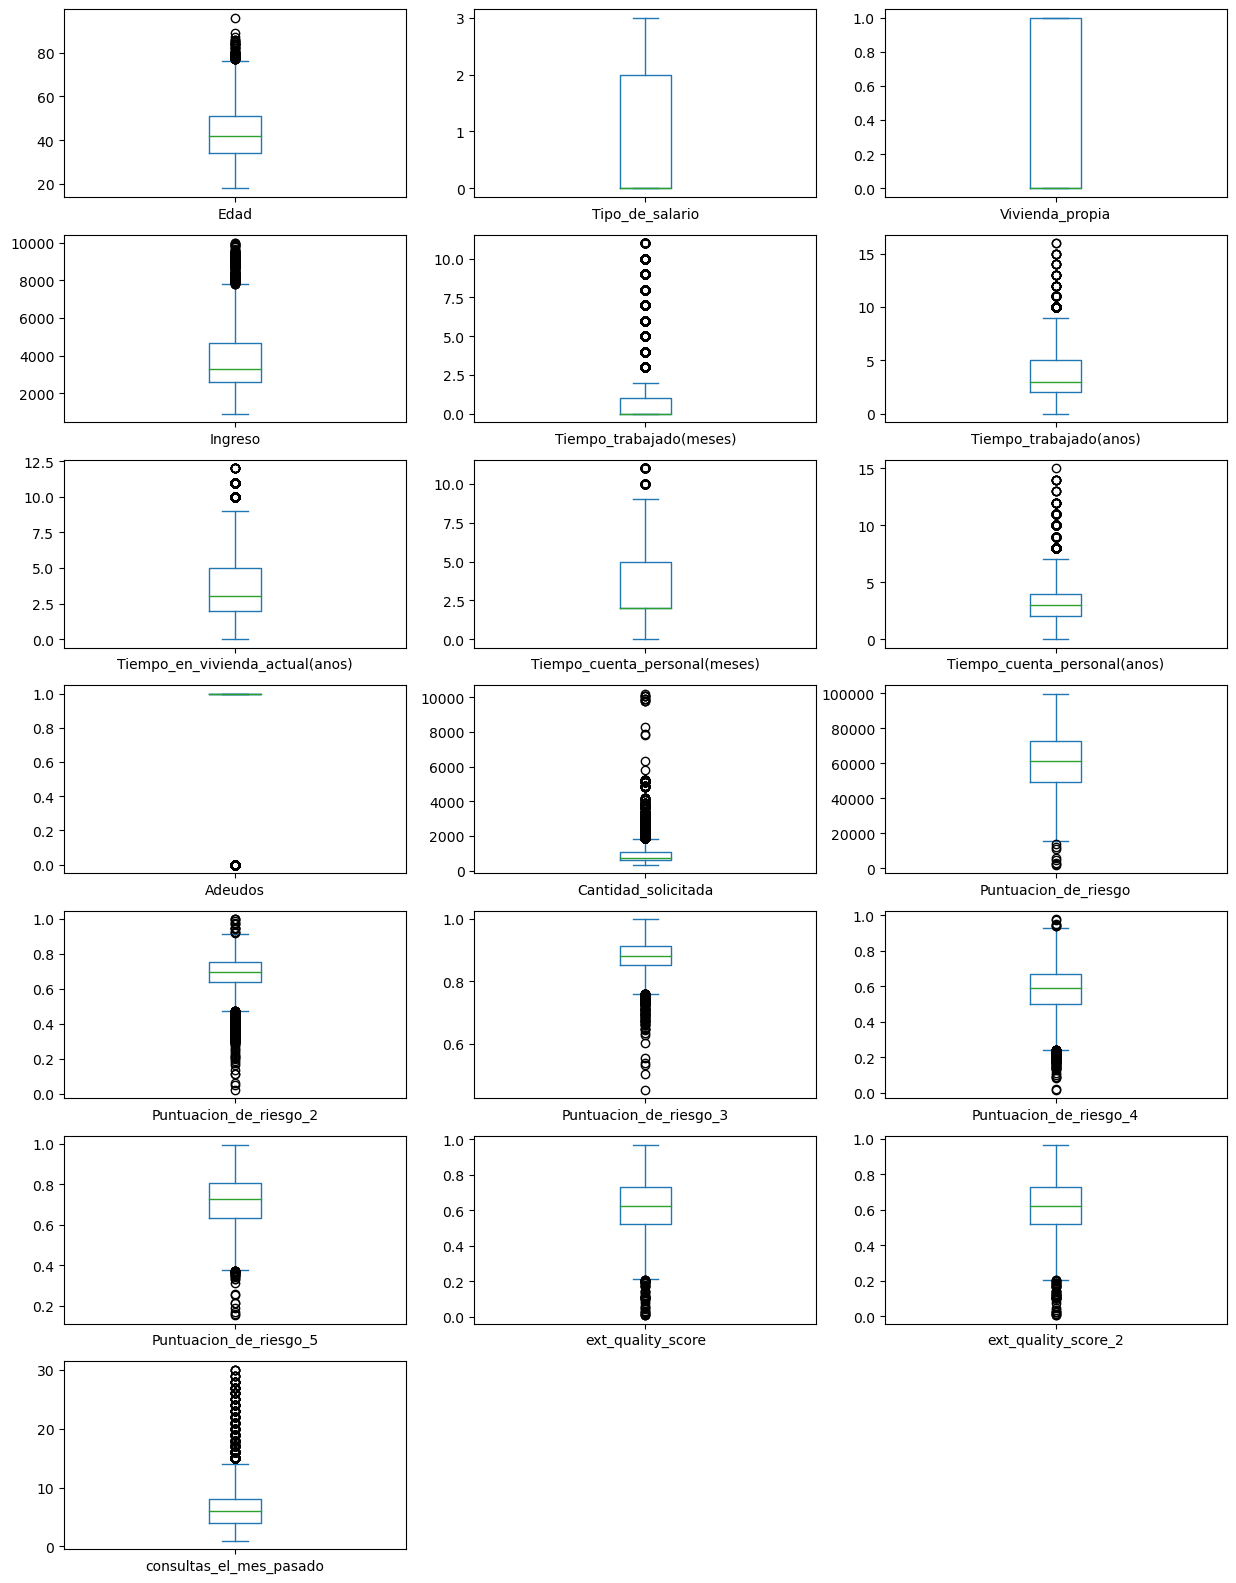

In [46]:
lista_columnas = ['Proceso_firma_electronica_completado']
df_original.drop(columns=lista_columnas).plot(kind="box", subplots=True, layout=(7,3), sharex=False, sharey=False, figsize=(15,20))
plt.show()

Con el dataframe resultante despues de eliminarlos:

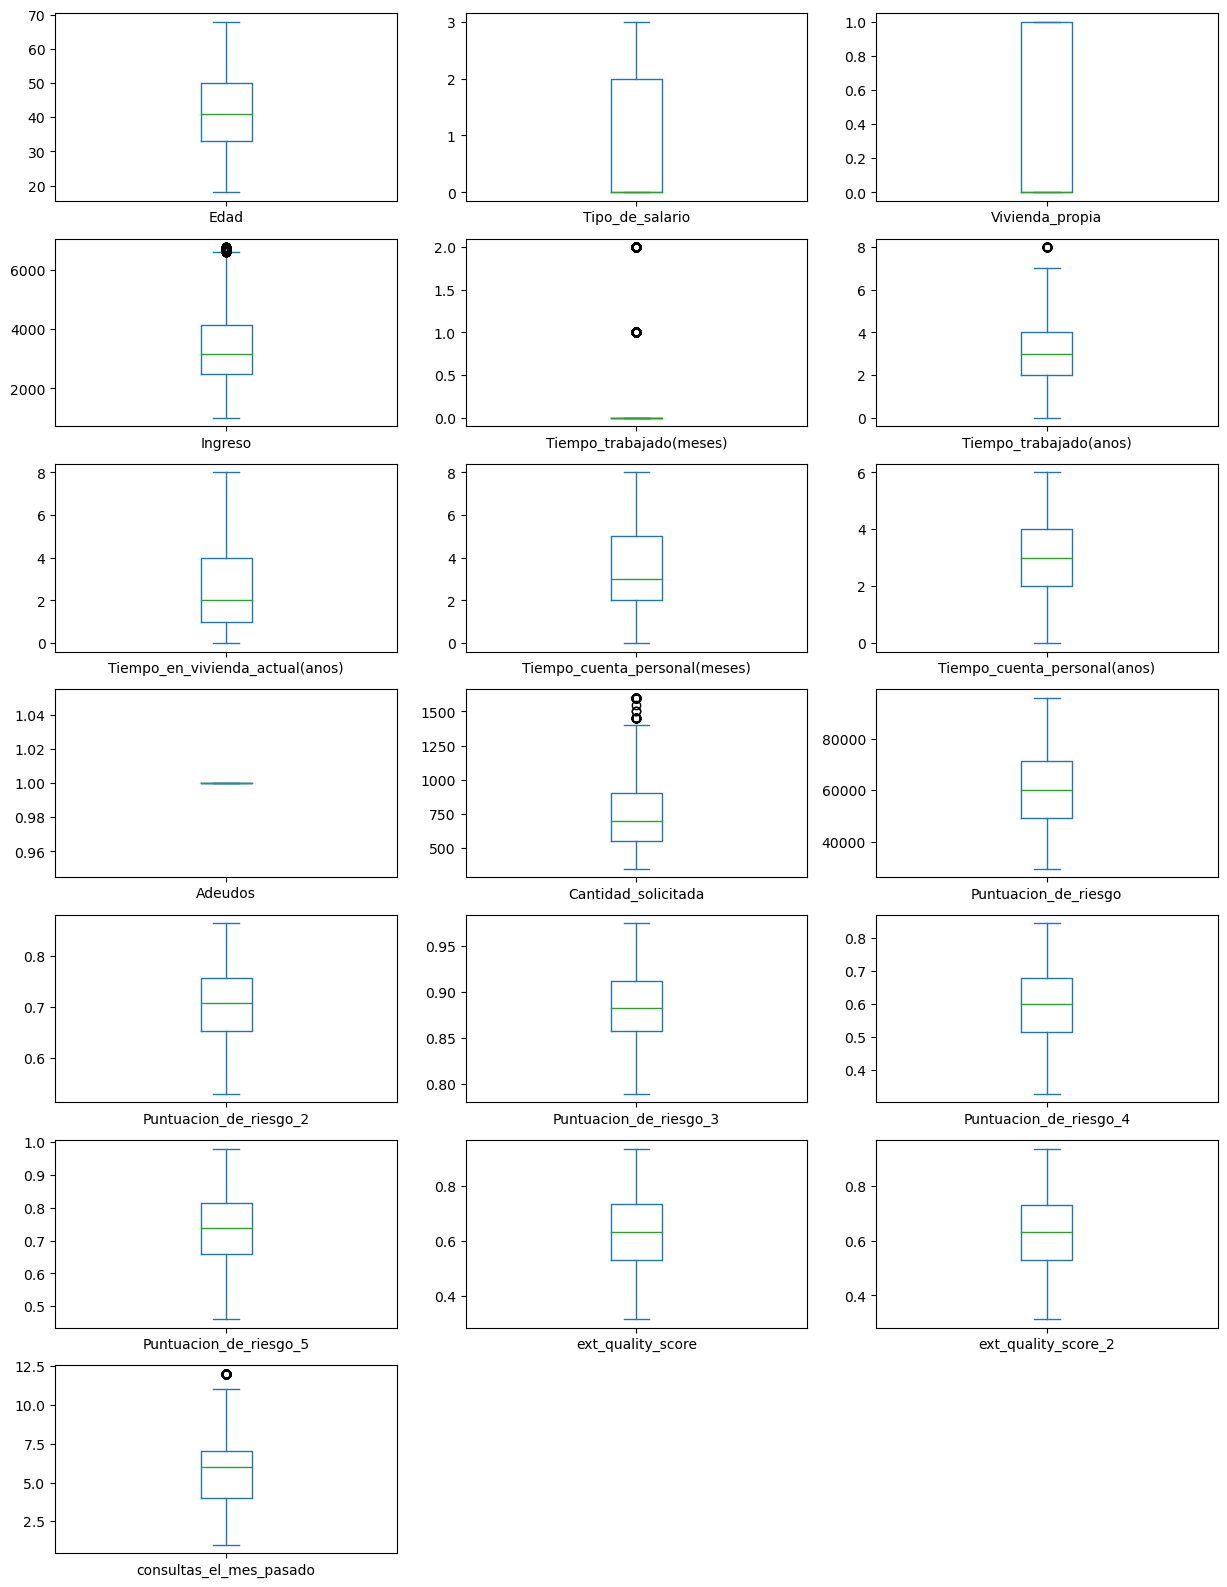

In [47]:
lista_columnas = ['Proceso_firma_electronica_completado']
df_atipico_manual.drop(columns=lista_columnas).plot(kind="box", subplots=True, layout=(7,3), sharex=False, sharey=False, figsize=(15,20))
plt.show()

Definitivamente estamos haciendo una limpieza profunda sobre los datos atipicos, sin embargo, el eliminar tanta cantidad de valores con respecto a los que iniciamos, en nuestra opinión, no reflejaria la verdad de los datos, ademas de reducir la muestra de entrenamiento, que podria reflejar o no una mejor precisión de la clasificación.

Es por ello que utilizaremos el modelo kNN para evaluar los datos atipicos.

### ¿Cómo utilizamos el modelo kNN?

Para su uso, utiliza un puntaje para identificar los valores atipicos, en este caso, la clase acepta tres tipos de métodos, nosotros utilizaremos el método de mediana para evaluar el puntaje con los vecinos, también consideraremos que tenemos una contaminación especifica, es decir, la proporción de valores atípicos en el conjunto de datos. Este algoritmo maneja que el dataset completo puede tener como máximo un **50%** como datos con valores atipicos. En nuestro caso, colocamos de forma arbitraria una contaminación del **18%**. 

In [48]:
clf = KNN(contamination=0.18, method='median', n_jobs=-1)
clf.fit(df.drop(columns=['Tipo_de_salario','Proceso_firma_electronica_completado']))
atipicos_pred = clf.predict(df.drop(columns=['Tipo_de_salario','Proceso_firma_electronica_completado']))

Aplicando el algoritmo vemos que considero que nuestro dataset presenta 2408 elementos que los considera atipicos dentro del modelo, aplicando el método en base a la mediana de los elementos.

In [49]:
def contador_elementos_array(elemento_a_buscar, arreglo):
    contador = 0 

    for i in arreglo:
        if elemento_a_buscar == i:
            contador +=1
    return contador

#type(atipicos_pred)
contador_elementos_array(1, atipicos_pred)

2408

Una vez realizado la predicción de valores atipicos los guardaremos en un dataframe aparte

In [50]:
df_outliers = df[atipicos_pred == 1]
df_outliers

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
14,50,0,0,3700,0,2,6,2,1,1,500,2800,0.467041,0.809313,0.624904,0.621841,0.462823,0.462823,16,1
17,58,3,1,3675,0,10,10,2,0,1,400,29150,0.691881,0.833958,0.765912,0.754194,0.824777,0.624777,9,1
40,43,2,1,4715,0,2,8,2,2,0,2400,84650,0.825571,0.944963,0.705914,0.690722,0.738059,0.838059,2,0
46,46,0,0,4548,0,3,3,2,4,1,2000,72400,0.598292,0.900184,0.617605,0.753998,0.591933,0.391933,23,1
57,62,3,1,6770,1,3,1,1,3,1,700,86200,0.662090,0.863182,0.637288,0.796271,0.809772,0.809772,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17870,57,0,1,8040,10,6,1,10,7,1,400,64500,0.760294,0.911497,0.621489,0.953953,0.648045,0.948045,6,1
17875,41,0,0,5025,0,9,1,2,2,0,2100,78800,0.765571,0.891228,0.722964,0.783758,0.523063,0.623063,3,1
17878,48,2,1,7155,6,2,7,6,8,1,1300,77050,0.638645,0.848469,0.471878,0.632073,0.562237,0.762237,2,1
17883,39,3,1,9834,0,5,4,2,4,0,400,47800,0.577252,0.784477,0.515618,0.616789,0.589720,0.489720,20,0


In [51]:
df_outliers.describe()

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
count,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000
mean,45.720515,0.953904,0.509136,5220.330150,1.065199,3.906146,3.843854,3.233804,3.558555,0.776163,1890.498339,68311.254153,0.691371,0.881339,0.597716,0.731872,0.626768,0.626228,6.469269,0.596346
std,11.390798,1.215446,0.500020,2030.256546,2.360417,2.357954,2.890272,2.087350,2.117816,0.416901,1215.098101,18905.096220,0.093216,0.058338,0.124418,0.119245,0.149169,0.150430,3.773155,0.490732
min,18.000000,0.000000,0.000000,905.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,350.000000,2100.000000,0.218361,0.554543,0.088819,0.253027,0.010184,0.006622,2.000000,0.000000
25%,37.000000,0.000000,0.000000,3608.250000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,900.000000,54750.000000,0.640669,0.850846,0.518929,0.647854,0.526026,0.524128,4.000000,0.000000
50%,45.000000,0.000000,1.000000,5192.500000,0.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1700.000000,71425.000000,0.700618,0.881156,0.603853,0.743176,0.630903,0.633541,6.000000,1.000000
75%,53.000000,2.000000,1.000000,6656.250000,0.000000,5.000000,6.000000,5.000000,4.000000,1.000000,2700.000000,83062.500000,0.755804,0.921510,0.687279,0.819765,0.742824,0.741742,8.000000,1.000000
max,84.000000,3.000000,1.000000,9985.000000,11.000000,15.000000,12.000000,11.000000,12.000000,1.000000,10200.000000,99750.000000,0.999997,0.998833,0.976803,0.996260,0.963075,0.964559,29.000000,1.000000


Viendo la aplicación de un modelo para la evaluación de datos atipicos, es dificil analizar la razón por la cual los tomo con respecto a los demás. De primera vista se puede ver que las columnas tienen almacenado, en algunas de ellas un valor máximo con el que contaban los datos originales, dentro de los cuales no es el valor comun en algunas columnas.

Veremos que pasa el graficarlo.

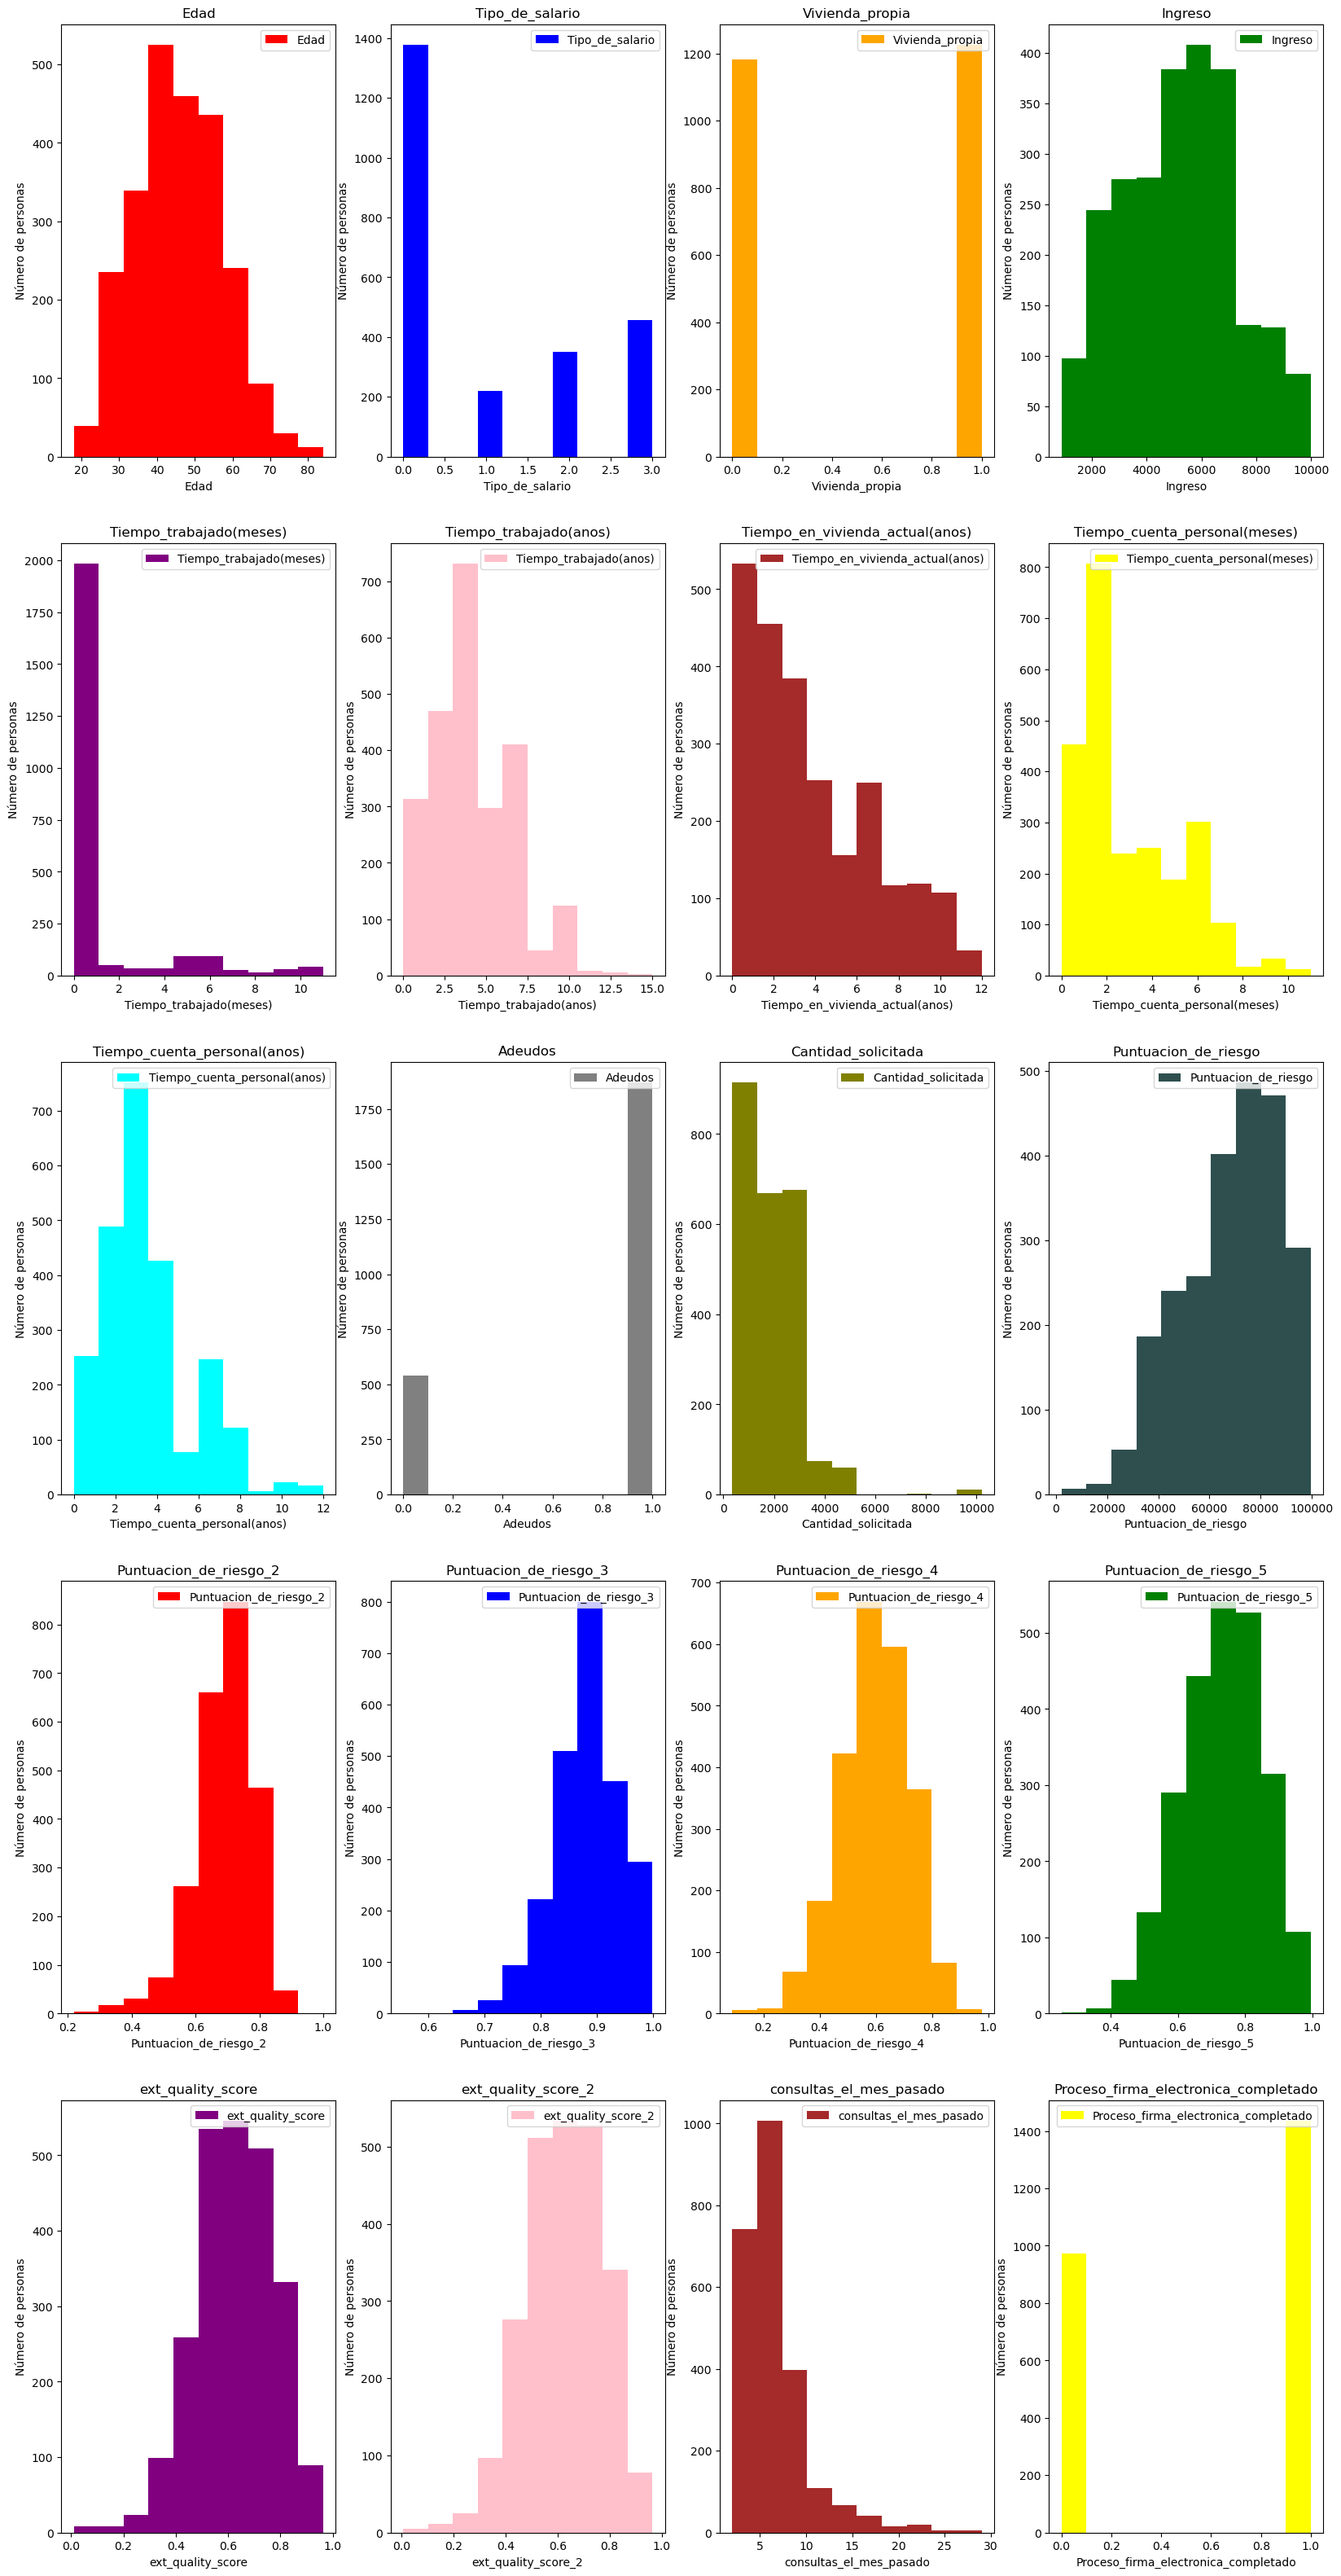

In [52]:
#lista_columnas = ['Proceso_firma_electronica_completado']
histogramas(df_outliers)

Podemos notar que tomo los datos menos comunmente observables, como los valores extremos de ciertas columnas, como ejemplo la cantidad solicitada es una gran representación de ello, ya que cuenta con una distribución de todos los datos ya sea para un lado para la izquieda o para la derecha.

Veremos más adelante si consiguio eliminar la mayor cantidad de datos atipicos.

Por ultimo, eliminamos de los datos atipicos del dataframe actual que estamos trabajando.

In [53]:
df = df[atipicos_pred == 0]
df

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,40,0,1,3135,0,3,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,61,3,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,23,3,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,40,0,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,33,2,0,3590,0,5,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17902,54,0,0,2620,5,2,1,4,2,1,600,55450,0.638183,0.973020,0.502234,0.731239,0.579557,0.679557,6,0
17903,31,1,0,3245,0,5,3,2,6,1,700,71700,0.691126,0.928196,0.664112,0.838012,0.727705,0.627705,2,0
17905,46,3,0,2685,0,5,1,1,8,1,1200,59650,0.677975,0.918141,0.687981,0.939101,0.472045,0.672045,9,0
17906,42,0,0,2515,0,3,5,6,1,1,400,80200,0.642741,0.885684,0.456448,0.686823,0.406568,0.406568,3,1


## Diagramas de caja

### ¿Qué es?

Un diagrama de caja es un método para representar gráficamente una serie de datos numéricos a través de sus cuartiles. De esta manera, se muestran a simple vista la mediana y los cuartiles de los datos, y también pueden representarse sus valores atípicos (altamente dispersos).

### ¿Qué es la dispersión?

Se refiere a cuanta distancia del centro se encuentran los datos

### ¿Cómo interpretar el gráfico?

#### Primer cuartil

El 25% de los valores son menores o igual a este valor. **En los gráficos del dataframe, este valor se representa en la parte inferior, en la linea que forma la caja.**

#### Mediana o Segundo Cuartil

Divide en dos partes iguales la distribución. De forma que  el 50% de los valores son menores o igual a este valor.**Este valor se representa en la linea verde que se encuentra dentro de la caja.**

#### Tercer cuartil
El 75% de los valores son menores o igual a este valor.**Se representa por la linea superior que dibuja la caja.**

#### Rango Intercuartílico (IQR)
Diferencia entre el valor del tercer cuartil y el primer cuartil. **Formula  IQR = Q3 - Q1** 

#### Lineas que se extienden más haya de la caja

Son los puntos más alejados que aún se consideran valores típicos( es decir, que se encuentran a menos de 1.5 IQR de los cuartiles), más haya de esas lineas divisoras, se encuentran los puntos que representan los valores atipicos con los que cuentan las columnas.

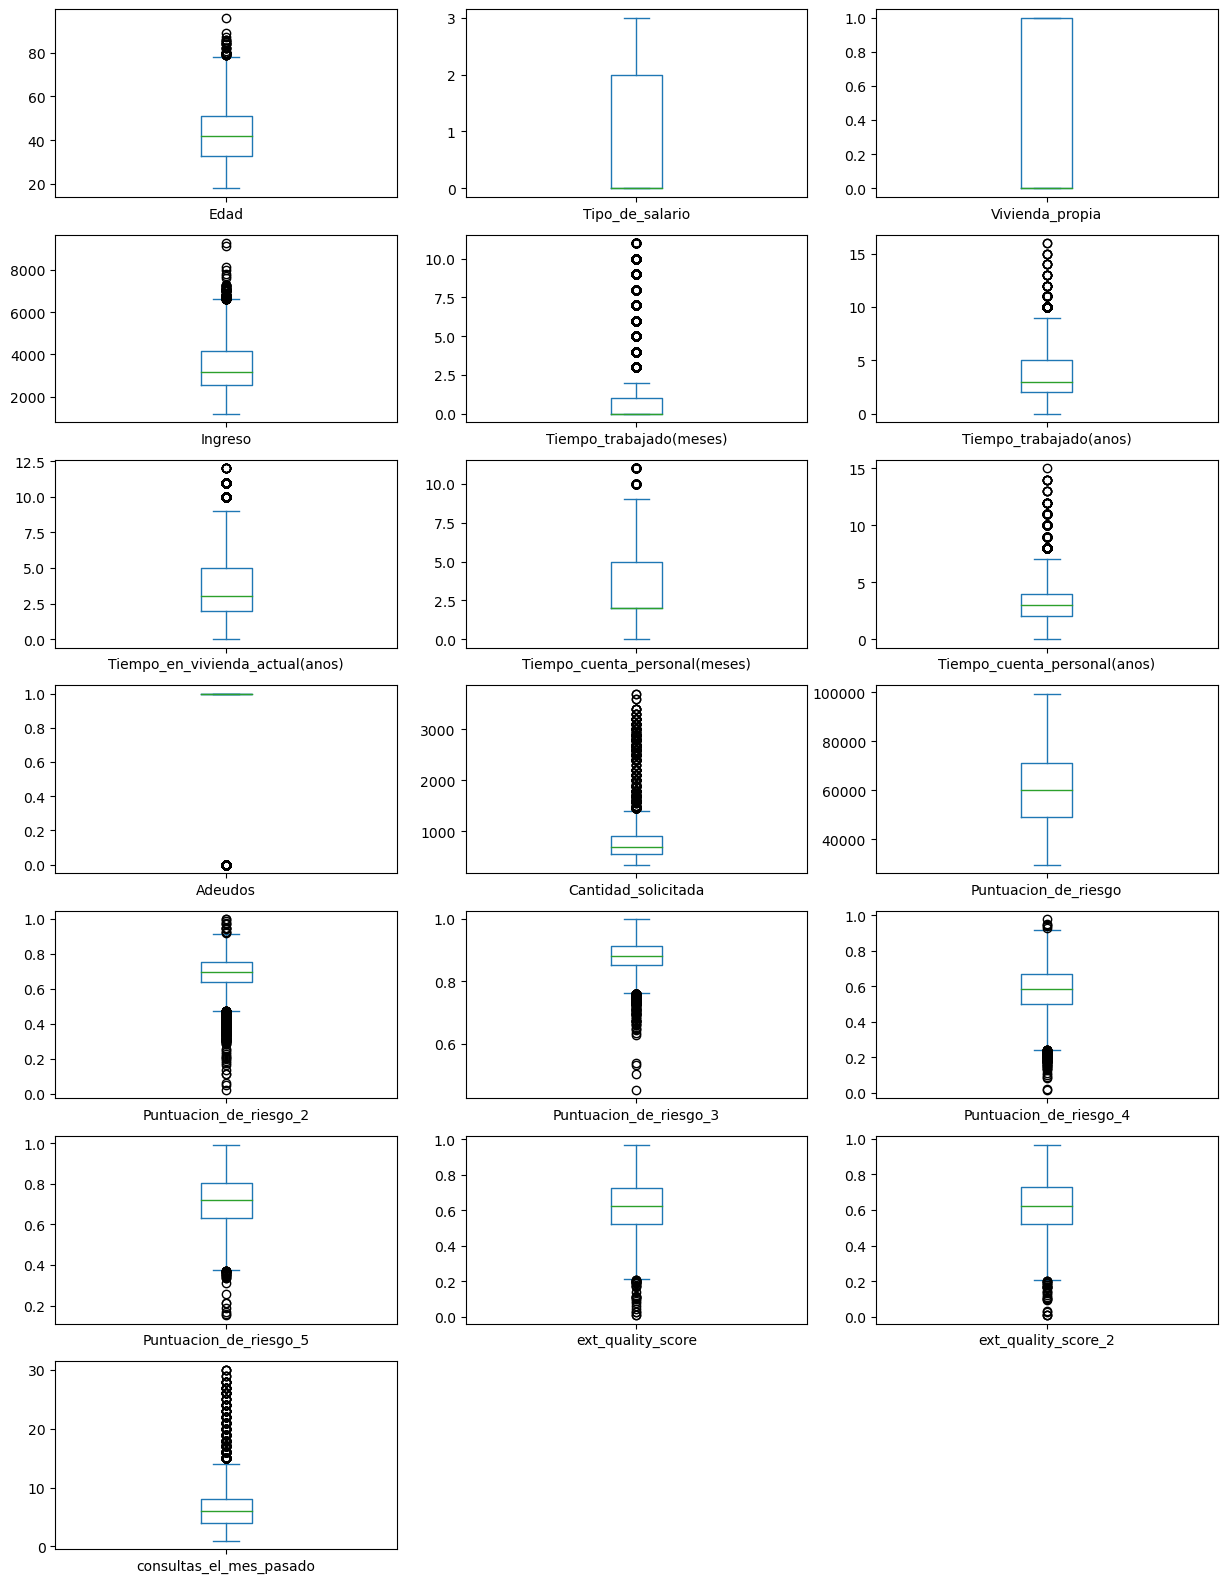

In [54]:
lista_columnas = ['Proceso_firma_electronica_completado']
df.drop(columns=lista_columnas).plot(kind="box", subplots=True, layout=(7,3), sharex=False, sharey=False, figsize=(15,20))
plt.show()

Al momento de graficar las columnas en forma de caja o cuartiles se puede notar que la mayoria de ellas aun presentan datos atipicos a pesar de la limpieza hecha anteriormente con el modelo de k vecinos más cercanos, y como antes mencionado se refiere a que son datos muy alejados del centro o tambien llamado mediana.

## Diagramas de violin

### ¿Qué son los diagramas de violin?
Este gráfico es una combinación de un diagrama de cajas y bigotes y un diagrama de densidad girado y colocado a cada lado, para mostrar la forma de distribución de los datos.

### ¿Para qué se utiliza?
Un diagrama de violín se utiliza para visualizar la distribución de los datos y su densidad de probabilidad.

### ¿Porqué no solo aplicar el diagrama de cajas si funcionan para lo mismo?
Los diagramas de cajas y bigotes están limitados a su visualización de los datos, ya que su simplicidad visual tiende a ocultar detalles significativos sobre cómo se distribuyen los valores en los datos. Por ejemplo, con los diagramas de cajas y bigotes no puedes ver si la distribución es bimodal o multimodal. 

### Posibles desventajas
Si bien los diagramas de violín incluyen más información, pueden estar mucho más abarrotados que los diagramas de cajas y bigotes. 

### Simbología del diagrama
La barra negra gruesa en el centro representa el intervalo intercuartil, la barra negra fina que se extiende desde ella, representa el 95 % de los intervalos de confianza, y el punto blanco es la mediana.



## Análisis de las características con gráfico de violin

<AxesSubplot:xlabel='Edad'>

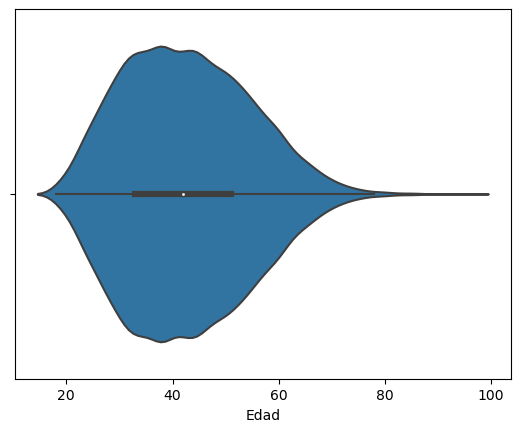

In [55]:
sns.violinplot(data=df, x="Edad")

Podemos observar que la concentración de los datos de la edad de los solicitantes a la firma electronica es mayormente entre los 30 a 50 años, lo que reflejaria la mediana de la información, se podria decir que es la edad en la que el trabajo es la vida cotidiana de las personas y también la necesidad de solicitar un prestamo. Basado en eso, las personas de la tercera edad lo realizan en mucho medida, casi nula, basado en nuestra muestra.

<AxesSubplot:xlabel='Tipo_de_salario'>

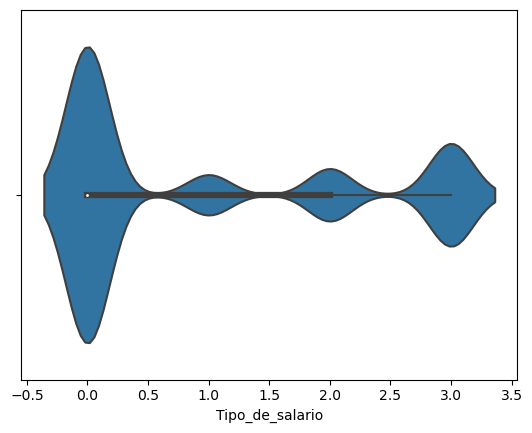

In [56]:
sns.violinplot(data=df, x="Tipo_de_salario")

Basado en información previa, esta columna maneja datos categoricos y fueron etiquetados previamenten en el documento, es por ello que el violin se refleja de esta forma. Para tener contexto tenemos la siguiente descripción.

In [57]:
le.classes_

array(['bi-weekly', 'monthly', 'semi-monthly', 'weekly'], dtype=object)

Si tomamos el principio como un 0 en el arreglo, tenemos que la mayoria de los que solicitan una firma electronica, tienen un empleo en el cual perciben su salario de forma quincenal, intuyendo, ya que el el dataset fue obtenido de kaggle y la información del mismo esta en ingles, podriamos decir que se trata de Estados Unidos o cualquier país de habla inglesa, en cuyo caso, de donde se obtuvo la información, la mayoria de las personas se les paga en quincenas, despues le seguiria semanal y en menor medida las otras.

Una razón de que las personas que tienen pagos quincenales y semanales requieran de un prestamo podria ser el salrio bajo que perciben, podriamos verlo tambíen.

<AxesSubplot:xlabel='Tipo_de_salario', ylabel='Ingreso'>

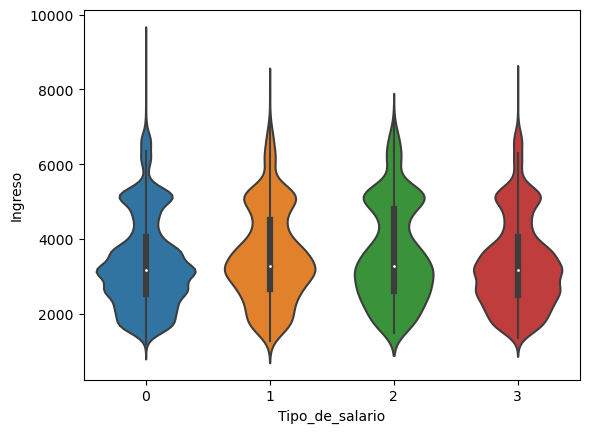

In [58]:
sns.violinplot(data=df, x="Tipo_de_salario",y="Ingreso")

Viendo la frecuencia de salario de cada tipo de sueldo, claramente se puede observar una mayor concentración entre los 2 mil y 4 mil dolares para los pagos quincenales y semanales, con picos altos y bajos de forma agresiva, por lo que no es constante. A diferencia de los pagos mensuales y 2 veces al mes, ya que estos tienen una forma casi perfecta de un violin, por lo que se puede ver que estos mantienen una distribución normal entre los datos de la muestra.

<AxesSubplot:xlabel='Ingreso'>

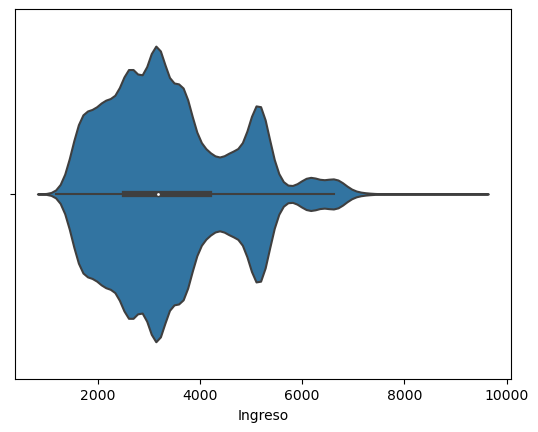

In [59]:
sns.violinplot(data=df, x="Ingreso")

Continuando con el gráfico exclusivamente de los ingresos, se puede ver que existe, en el dataset con su previo preprocesamiento, una concentración a la baja de los datos, con un gran pico exactamente en la media de los datos, aproximadamente unos 3 mil dolares.

Vamos a ver si los solicitantes de la firma cuentan con una vivienda propia, puede que esto nos muestre más información.

Para ello primero ordenamos los datos en un intervalo, si lo manejaramos como una distribución de frecuencias, para calcular la cantidad de intervalos se podia usar la regla de sturges = 1 + 3.332 * log(n), sin embargo, realizandolo saldria 

In [60]:
k_intervalos = 1 + 3.332 * np.log(len(df))
k_intervalos

33.14911954928725

y se veria muy mal en un gráfico, asi que por conveniencia lo dividiremos en 5 grupos como se muestra abajo.

In [61]:
bins = [1184,2803,4422,6041,7660,9281] # Rango de ingresos
names = ['Muy bajo','bajo','Medio','Alto','Muy alto']

intervalo_arreglo = pd.cut(df["Ingreso"], bins, labels = names)

Una vez agrupado el intervalo, separaremos los datos y los agruparemos para su conteo por medio de un crosstab, como se muestra se encuentran todos los datos del dataframe.

In [62]:
pd.crosstab(intervalo_arreglo,df['Vivienda_propia'], margins=True)

Vivienda_propia,0,1,All
Ingreso,,,
Muy bajo,3802,1999,5801
bajo,3531,2646,6177
Medio,1518,1391,2909
Alto,258,349,607
Muy alto,3,3,6
All,9112,6388,15500


Almacenaremos este crosstab en un nuevo dataframe.

In [63]:
intervalo_vivienda_propia = pd.crosstab(intervalo_arreglo,df['Vivienda_propia'])

Por ultimo graficamos el resultado

<AxesSubplot:xlabel='Ingreso'>

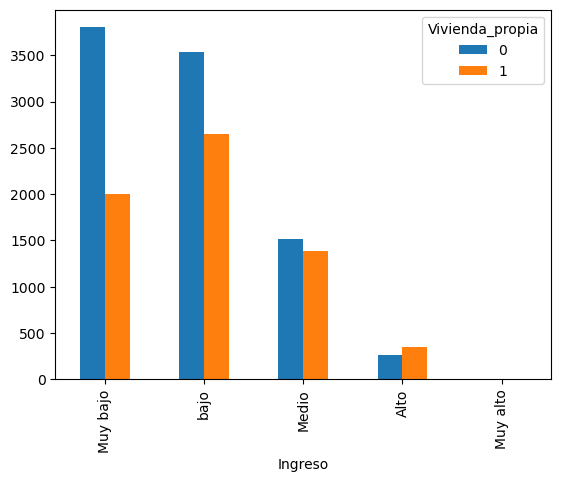

In [64]:
intervalo_vivienda_propia.plot.bar()

Podemos observar, primeramente que la mayoria de las personas que se encuentran en el dataset tiene un rango de salario de "medio" a "muy bajo" (considerando el rango que colocamos previamente para dividirlos).También, nuevamente hablando de los rangos de salario bajo, existe una cantidad de estas personas las cuales no cuentan con una vivienda propia, aqui podria encajar que las ciudades a donde pertenecen estas personas, el ser dueños de una vivienda podria resultar muy costoso, además de ser una de las razónes por las cuales quisieran obtener un prestamo, si fueran economicamente estables, seria complicado el solicitarlo (podria ser por baja administración de los ingresos).

<AxesSubplot:xlabel='Tiempo_trabajado(meses)'>

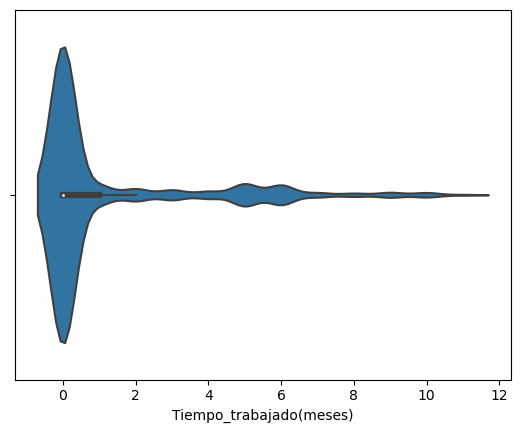

In [65]:
sns.violinplot(data=df, x="Tiempo_trabajado(meses)")

El gráfico de arriba presenta que practicamente todos los datos (inclusive el diagrama de caja), tiende a 0 en la mayoria, podria ser que, junto con la columna tiempo años trabajados se haga una contabilización, como si se tratara de unidades, decenas, centenas etc. Es decir, no porque sea 0 significa que no han trabajado nada (que puede ser una posibilidad), si no que una vez cumplido el año, el contador de meses se reduce a 0 y el año aumenta en 1.

Por eso supongo que cuando se hicieron esta captura de información, la mayoria de las personas podian decir eh trabajado dos, tres, 4 años, no dirian eh trabajado 4 años 5 meses y tres dias, asi que la mayoria esta en 0 por esa razón.

<AxesSubplot:xlabel='Tiempo_trabajado(anos)'>

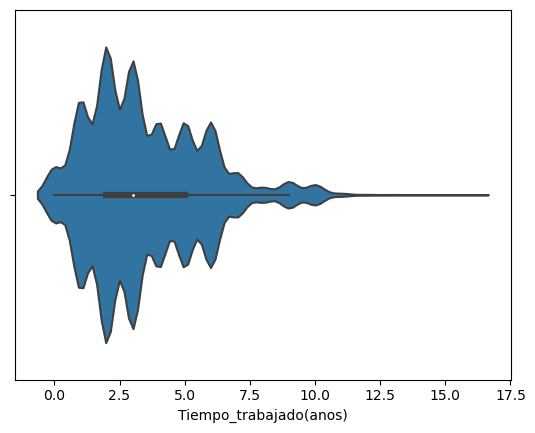

In [66]:
sns.violinplot(data=df, x="Tiempo_trabajado(anos)")

Aqui la información se concentra entre el años y los 6 años de trabajo, siendo la media aproximadamente 3 años de trabajo, creo que esta columna es importante, al menos para cualquiera que le sirva saber si otorgar o no una firma electronica para un prestamo si la persona minimamente cuenta con una minima estabilidad economica para saber si es una persona a la cual darle o no un prestamo. No seria el único factor de utilidad pero sirve.

<AxesSubplot:xlabel='Tiempo_en_vivienda_actual(anos)'>

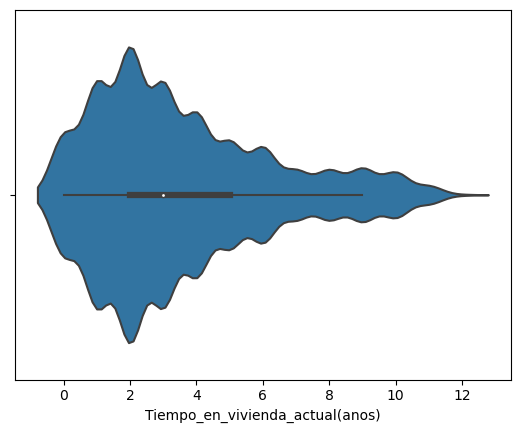

In [67]:
sns.violinplot(data=df, x="Tiempo_en_vivienda_actual(anos)")

Al tratarse de un proceso de tipo financiero este dataset, el conocer, por parte del que le dara el prestamo, con la firma, es necesario ver que tan segura sera su inversión, con esto podemos ver que los datos tienden a mostrar que las personas que van a solicitar una firma electronica han vivido en su casa actual aproximadamente 2 años, un poco por debajo de la mediana que son 3.

Veremos cuantos de esas personas tienen viven en una casa propia o no.

In [68]:
pd.crosstab(df['Tiempo_en_vivienda_actual(anos)'],df['Vivienda_propia'], margins=True)

Vivienda_propia,0,1,All
Tiempo_en_vivienda_actual(anos),,,
0,921,394,1315
1,1538,872,2410
2,1996,1177,3173
3,1436,941,2377
4,1048,693,1741
5,659,471,1130
6,620,408,1028
7,265,256,521
8,197,338,535


Almacenandolo y graficandolo tenemos lo siguiente...

In [69]:
frecuencia_vivienda_y_propia = pd.crosstab(df['Tiempo_en_vivienda_actual(anos)'],df['Vivienda_propia'])

<AxesSubplot:xlabel='Tiempo_en_vivienda_actual(anos)'>

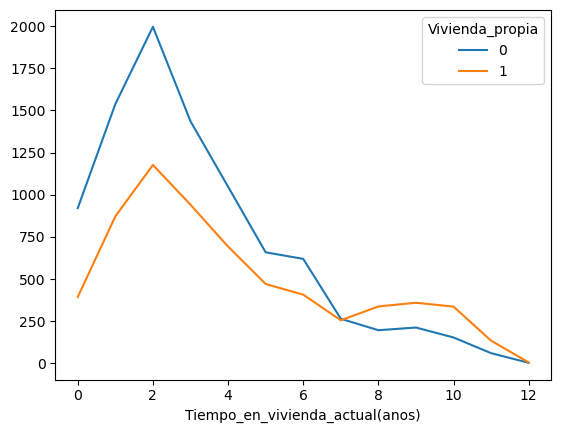

In [70]:
frecuencia_vivienda_y_propia.plot()

Observamos que existe, entre mas años se este en una vivienda actual, menor es el número de personas dentro de la muestra, ademas, las personas que no tienen vivienda, tienden a vivir aproximadamente dos años dentro de un mismo domicilio. 

Igual de las personas que tienen una vivienda propia, al punto en que se registro la información en el dataset, podemos suponer que han pasado dos años para la mayoria de las personas que han obtenido su vivienda propia desde la fecha en la adquirieron.

<AxesSubplot:xlabel='Tiempo_cuenta_personal(meses)'>

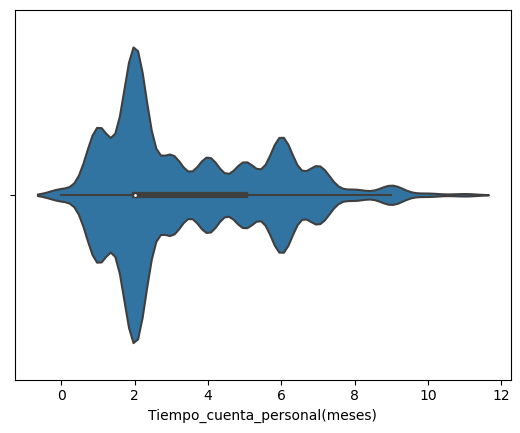

In [71]:
sns.violinplot(data=df, x="Tiempo_cuenta_personal(meses)")

Mismo caso que años trabajados, supongo que el tiempo que han estado en esa empresa financiera en cuestion de meses, que se manejara junto con la columna de años que veremos enseguida.

<AxesSubplot:xlabel='Tiempo_cuenta_personal(anos)'>

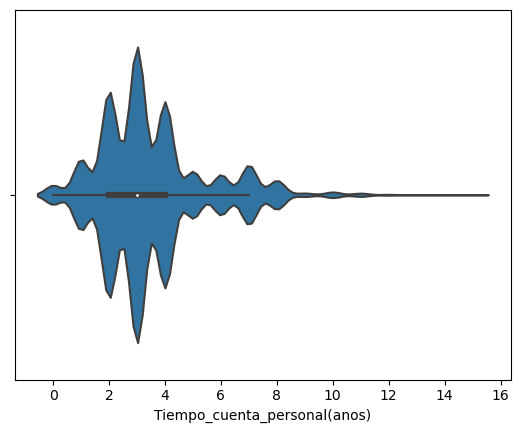

In [72]:
sns.violinplot(data=df, x="Tiempo_cuenta_personal(anos)")

En este violin (deformado), vemos que por lo general las personas estan con esa cuenta en esa empresa financiera de 2 a 4 años en el tiempo en que se obtuvo la información.

<AxesSubplot:xlabel='Adeudos'>

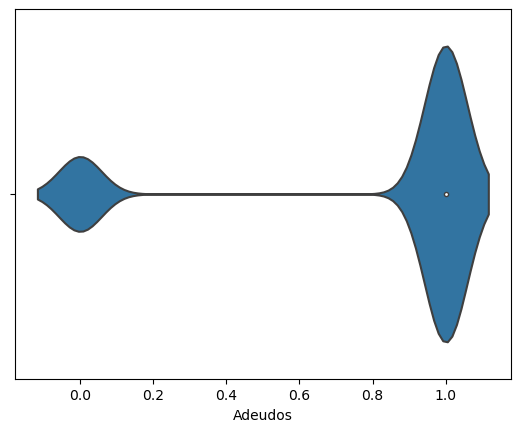

In [73]:
sns.violinplot(data=df, x="Adeudos")

Nuevamente, esta columna maneja valores categoricos, en este caso de tipo binaria, en este caso lo que nos dice el diagrama es que mayormente la cantidad de personas que se encuentra dentro de la muestra que solicitan una firma electronica para un prestamo tienen deudas, lo que tiene sentido viendo para que lo solicitan.

<AxesSubplot:xlabel='Cantidad_solicitada'>

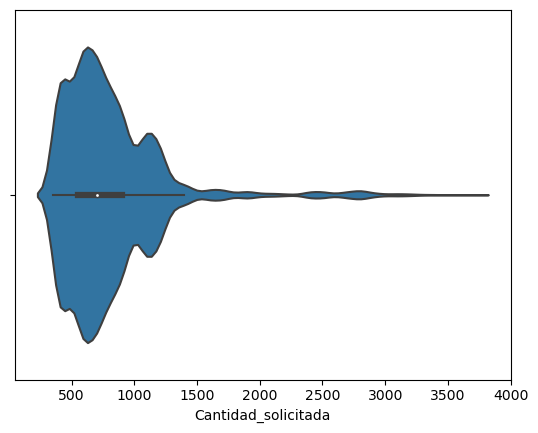

In [74]:
sns.violinplot(data=df, x="Cantidad_solicitada")

Considerando que el dataset es para una firma electronica de un prestamo, la cantidad solicitada se tratara de lo que la persona solicita como prestamo, en esta caso vemos que el dinero que se pide cae (practicamente en su totalidad), en una concentración que se encuentra en los 500 a 1500 dolares (suponiendo que son dolares), lo que resultaria en una cantidad un poco baja en mi opinión, por lo esta información podria ser de una empresa que ofrece prestamos rapidos que se anuncian en televisión.

<AxesSubplot:xlabel='Puntuacion_de_riesgo'>

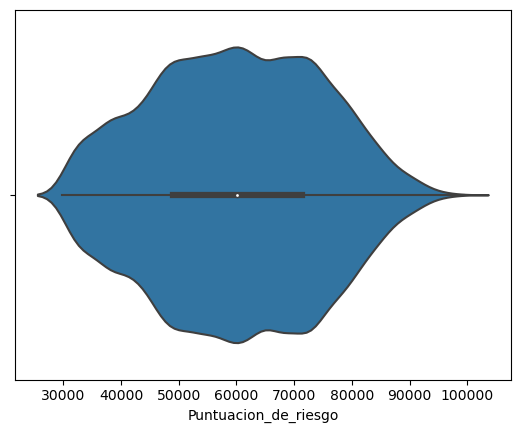

In [75]:
sns.violinplot(data=df, x="Puntuacion_de_riesgo")

Como se puede ver, aunque de forma un poco deformada, para la puntuación de riesgo que recibe cada persona, el gráfico de violin mostrado presenta una concentración de los valores hacia la mediana, por lo que más o todos los participantes en el dataset recibieron una puntuación similar (entre 5 mil y 7 mil de puntaje).

<AxesSubplot:xlabel='Proceso_firma_electronica_completado'>

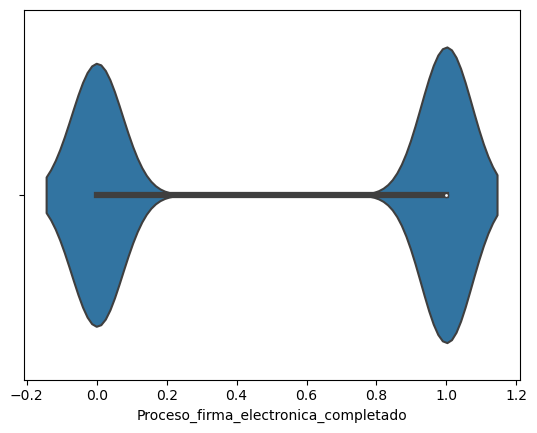

In [76]:
sns.violinplot(data=df, x="Proceso_firma_electronica_completado")

Al tratarse de una columna binaria, es la razón por la que aparecen asi los datos.

Como funcionamiento serviria para demostrar si los datos estan balanceados, se puede ver que el "tamaño" de los datos alcanza practicamente la misma cantidad de observaciones, por lo que no tendriamos problemas al entrenar el modelo en ese aspecto, ya que tenemos tanto observaciones negativas como positivas.

## Crosstabs

1. Se desea saber cuantos años tienen trabajando mientras cambia el tipo o ciclo de pago.

In [77]:
C1 = pd.crosstab (df.Edad,df.Tipo_de_salario,margins=True)
print(C1)

Tipo_de_salario     0     1     2     3    All
Edad                                          
18                 20     1     2     7     30
19                 26     2     6    11     45
20                 38     3     5    26     72
21                 43     3     3    23     72
22                 79     7     6    44    136
...               ...   ...   ...   ...    ...
86                  1     2     0     0      3
87                  1     0     0     0      1
89                  1     0     0     0      1
96                  0     1     0     0      1
All              9338  1271  1653  3238  15500

[72 rows x 5 columns]


Como resultado se puede ver que por ejemplo las personas que 22 años y les pagan mensualmente son un total de 79 empleados.

2. Se desea saber que empleados calculados por edades trabajan en casa y quien no tienen casa propia

In [78]:
C2 = pd.crosstab(df.Edad,df.Vivienda_propia,margins=True)
print(C2)

Vivienda_propia     0     1    All
Edad                              
18                 20    10     30
19                 35    10     45
20                 56    16     72
21                 56    16     72
22                 98    38    136
...               ...   ...    ...
86                  0     3      3
87                  1     0      1
89                  0     1      1
96                  0     1      1
All              9112  6388  15500

[72 rows x 3 columns]


Como se puede visualizar un ejemplo los empleados con 22 años, 98 de ellos tienen casa propia, mientras 38 no.


3. Se desea saber los empleados que le paguen semanalmente y que tengan 3 años trabajando

In [79]:
C3 = pd.crosstab(df.Tipo_de_salario=="weekly",df['Tiempo_en_vivienda_actual(anos)']==3,margins=True)
print(C3)

Tiempo_en_vivienda_actual(anos)  False  True    All
Tipo_de_salario                                    
False                            13123  2377  15500
All                              13123  2377  15500


Como se puede visualizar 2377 empleados han salido positivo en las dos condiciones que son que le paguen por semana y tengan a lo menos 3 años trabajados.

4. Se quiere saber que edades si cuentan con su firma electronica

In [80]:
C4 = pd.crosstab(df.Edad,df.Proceso_firma_electronica_completado,margins=True) 
print(C4)

Proceso_firma_electronica_completado     0     1    All
Edad                                                   
18                                      11    19     30
19                                      20    25     45
20                                      28    44     72
21                                      23    49     72
22                                      48    88    136
...                                    ...   ...    ...
86                                       3     0      3
87                                       0     1      1
89                                       1     0      1
96                                       1     0      1
All                                   7297  8203  15500

[72 rows x 3 columns]


Como se puede observan en esta tabla por ejemplo los empleados con 19 años de los 45, 25 pudieron sacar su firma electronica mientras 20 no.

5. Se quiere saber cuales son las edades que no duran ningun año trabajando

In [81]:
C5 = pd.crosstab(df.Edad,df['Tiempo_trabajado(anos)']==0,margins=True)
print(C5)

Tiempo_trabajado(anos)  False  True    All
Edad                                      
18                         26     4     30
19                         37     8     45
20                         65     7     72
21                         65     7     72
22                        125    11    136
...                       ...   ...    ...
86                          3     0      3
87                          1     0      1
89                          1     0      1
96                          1     0      1
All                     14871   629  15500

[72 rows x 3 columns]


Como se puede observar un ejemplo es que los empleados con 18 años de los 30 solo 21 no han durado ni un mes trabajando, de lo contrario 9 si.

## Estandarización de los datos

### ¿Qué es la estandarización?

Es el proceso que corresponde a igualar la información de diferentes fuentes (en este caso de columnas) en una misma escala.

### ¿Para qué sirve?

* Permite asegurarnos de que tendremos datos útiles y fácilmente utilizables para cualquier proceso de analisis.
* Le damos uniformidad a los datos, con el fin de que la escala de estos influya en el proceso de algún algoritmo.



A continuación realizaremos la estandarización solo a las características que consideramos necesarias, aun sin tomar en cuenta las caracteríticas que utilizaremos en el modelo de clasificación.

In [82]:
sc = StandardScaler()
df_estandarizar = df[['Edad','Ingreso','Tiempo_trabajado(meses)','Tiempo_trabajado(anos)','Tiempo_en_vivienda_actual(anos)','Tiempo_cuenta_personal(meses)','Tiempo_cuenta_personal(anos)','Cantidad_solicitada','Puntuacion_de_riesgo','Puntuacion_de_riesgo_2','Puntuacion_de_riesgo_3','Puntuacion_de_riesgo_4','Puntuacion_de_riesgo_5','ext_quality_score','ext_quality_score_2','consultas_el_mes_pasado']]
datos_estandarizados = sc.fit_transform(df_estandarizar)
df_estandar = pd.DataFrame(data = datos_estandarizados, columns= df_estandarizar.columns )
df_estandar.head()

,Edad,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado
0,-0.218243,-0.225295,-0.500617,-0.209055,-0.199607,1.138055,-0.774893,-0.606683,-1.644121,0.517540,0.476796,-0.745387,-1.657174,-0.301214,-1.740516,0.969196
1,1.547775,-0.189006,-0.500617,1.131228,-0.199607,-0.652202,1.817114,-0.487447,-2.062694,0.529888,0.059823,1.060174,0.912922,0.782769,0.067290,0.695771
2,-1.647877,-1.511531,1.992550,-1.549339,-1.299468,1.585619,-1.293294,-0.845154,-1.758277,-0.530983,-2.062494,0.112997,0.382071,-0.657273,-0.649227,0.148920
3,-0.218243,1.464151,-0.500617,1.131228,-0.932848,-0.652202,1.817114,-0.248976,-1.232466,-0.284080,1.539411,1.495381,0.519068,1.230192,-0.208930,0.422345
4,-0.806916,0.141625,-0.500617,0.684467,-0.566227,-0.652202,2.335515,0.704910,-0.422993,-0.815668,-0.375252,0.260737,-0.419035,0.883452,0.891681,1.516047


No lo aplicamos a las columnas: 
* Tipo de salario 

Debido a que son valores etiquetados, no tendria sentido agregarlos.

* Vivienda propia
* Adeudos

Ya que se tratan de valores binarios, o lo tienen (1) o no lo tienen (0).

* Proceso de firma electronica completado

Ya que es de tipo binaria, ademas se trata de nuestra variable objetivo.



Cambiamos los datos a los estandarizados en el dataframe

In [83]:
df_estandar.columns.values

array(['Edad', 'Ingreso', 'Tiempo_trabajado(meses)',
       'Tiempo_trabajado(anos)', 'Tiempo_en_vivienda_actual(anos)',
       'Tiempo_cuenta_personal(meses)', 'Tiempo_cuenta_personal(anos)',
       'Cantidad_solicitada', 'Puntuacion_de_riesgo',
       'Puntuacion_de_riesgo_2', 'Puntuacion_de_riesgo_3',
       'Puntuacion_de_riesgo_4', 'Puntuacion_de_riesgo_5',
       'ext_quality_score', 'ext_quality_score_2',
       'consultas_el_mes_pasado'], dtype=object)

In [84]:
df.loc[:,df_estandar.columns.values] = df_estandar.values
df.head()

C:\Users\Ismael\AppData\Local\Temp\ipykernel_3712\1941200518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,df_estandar.columns.values] = df_estandar.values


,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,-0.218243,0,1,-0.225295,-0.500617,-0.209055,-0.199607,1.138055,-0.774893,1,-0.606683,-1.644121,0.517540,0.476796,-0.745387,-1.657174,-0.301214,-1.740516,0.969196,1
1,1.547775,3,0,-0.189006,-0.500617,1.131228,-0.199607,-0.652202,1.817114,1,-0.487447,-2.062694,0.529888,0.059823,1.060174,0.912922,0.782769,0.067290,0.695771,0
2,-1.647877,3,0,-1.511531,1.992550,-1.549339,-1.299468,1.585619,-1.293294,1,-0.845154,-1.758277,-0.530983,-2.062494,0.112997,0.382071,-0.657273,-0.649227,0.148920,0
3,-0.218243,0,0,1.464151,-0.500617,1.131228,-0.932848,-0.652202,1.817114,1,-0.248976,-1.232466,-0.284080,1.539411,1.495381,0.519068,1.230192,-0.208930,0.422345,1
4,-0.806916,2,0,0.141625,-0.500617,0.684467,-0.566227,-0.652202,2.335515,1,0.704910,-0.422993,-0.815668,-0.375252,0.260737,-0.419035,0.883452,0.891681,1.516047,0


Aplicando nuevamente el histograma para visualizar los datos podemos observar que la distribución de estos no se vieron afectadas, simplemente cambia la escala en la que estos se manejan, permitiendo trabajar con la misma información, pero sin la afectación que ocurriria si los datos no fueran tratados si es que aplicamos un modelo de machine learning o de analisis de datos en general.

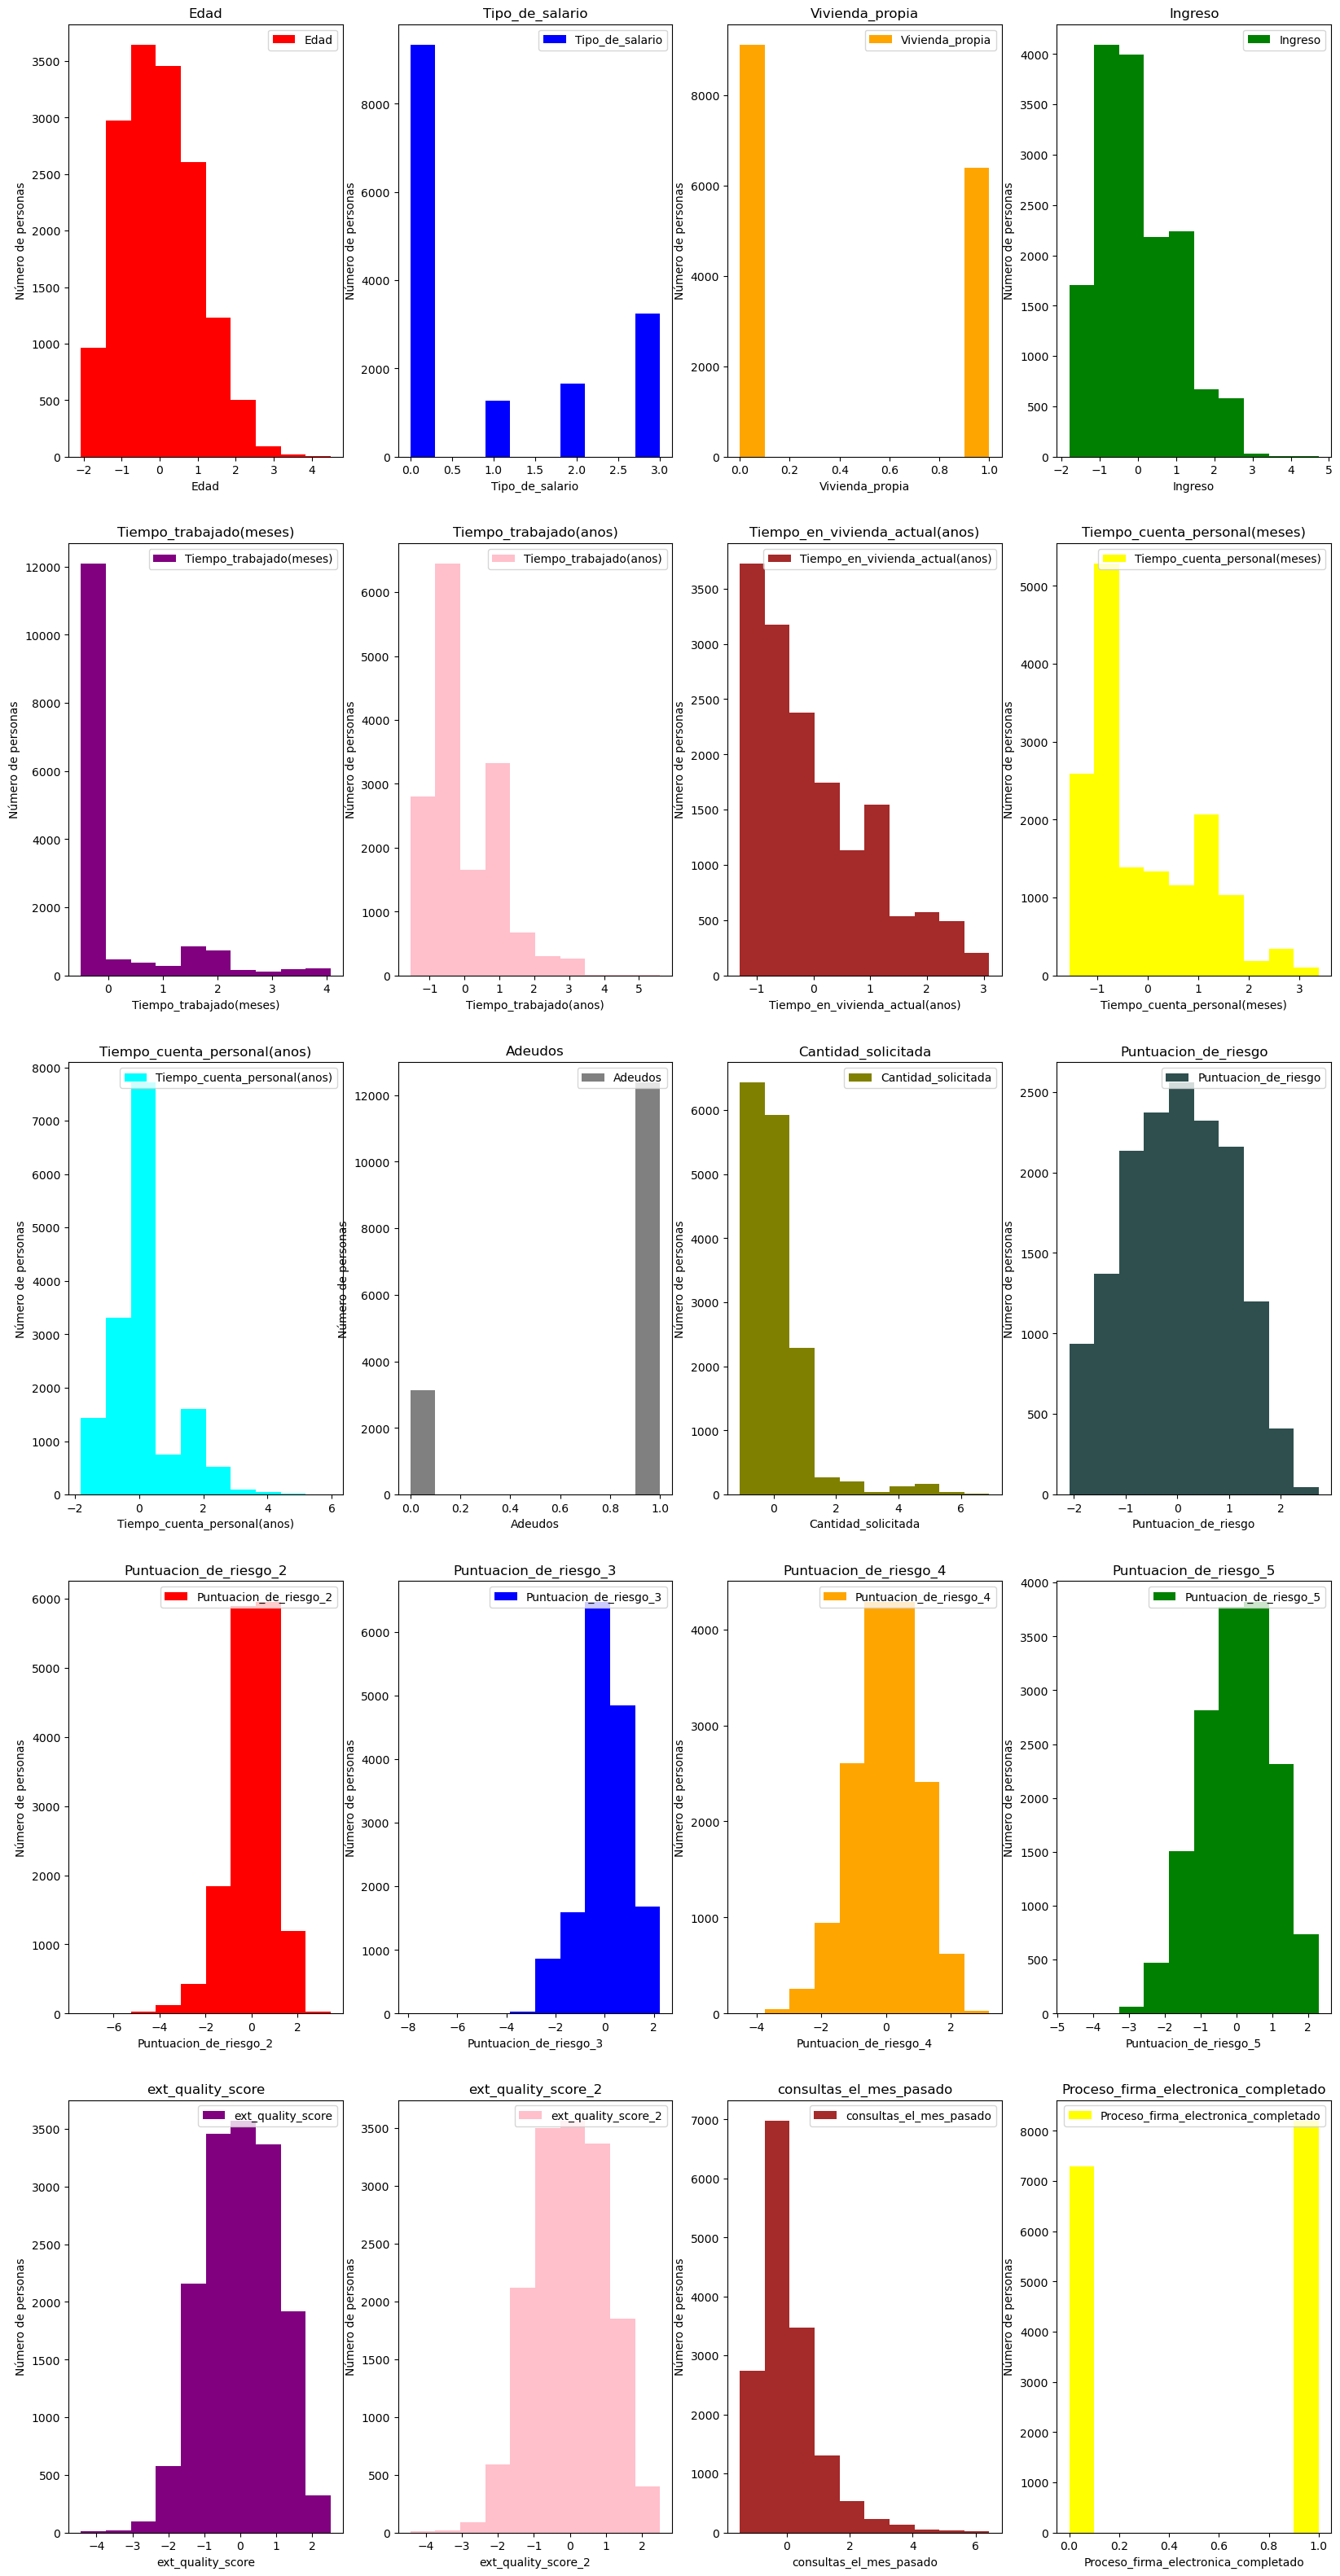

In [85]:
histogramas(df)

## Correlación entre características

### ¿Qué es la correlación?

Es una medida estadística que expresa hasta qué punto dos variables están relacionadas linealmente.

### ¿Para qué sirve?

* Esto sirve para comprobar que relacion tienen dos variables, y como es que pueden o no cambiar juntas al modificar alguna.
* La correlación es útil para describir relaciones simples entre datos. 
* Para la predicción de una variable (regresión lineal).

### Limitaciones 

Es importante saber que la correlación no nos informa sobre causas y efectos (Cuales son las variables dependientes e independientes).


In [86]:
correlacion = df.drop(columns=lista_columnas).corr(method="pearson")
correlacion

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado
Edad,1.000000,-0.022314,0.135856,0.161714,-0.097438,0.176417,0.137119,-0.008946,0.039145,-0.045358,0.057657,0.134744,-0.022645,0.117792,0.065243,0.092271,0.038489,0.046078,0.048364
Tipo_de_salario,-0.022314,1.000000,-0.011807,0.014921,0.025169,-0.016086,0.000615,-0.009200,0.002728,-0.000357,0.008988,-0.012506,0.008918,-0.045792,0.237454,0.174819,-0.004232,-0.010465,-0.029672
Vivienda_propia,0.135856,-0.011807,1.000000,0.116580,0.022597,0.014337,0.175158,0.021778,-0.048489,-0.074845,0.036947,0.083197,-0.009698,0.053396,-0.142631,-0.084708,0.013126,0.009116,0.018822
Ingreso,0.161714,0.014921,0.116580,1.000000,-0.063525,0.098680,0.056649,0.025410,-0.011679,-0.025467,0.224793,0.121387,-0.044565,0.054254,-0.021608,0.009445,-0.014400,-0.006881,0.067432
Tiempo_trabajado(meses),-0.097438,0.025169,0.022597,-0.063525,1.000000,-0.195801,-0.049890,0.216161,-0.017350,-0.008558,-0.020061,-0.037381,0.029688,-0.024857,-0.014766,-0.017834,-0.013015,-0.007863,-0.032225
Tiempo_trabajado(anos),0.176417,-0.016086,0.014337,0.098680,-0.195801,1.000000,0.339800,-0.051914,0.189830,0.013456,0.073678,0.082072,-0.059775,0.081024,-0.025570,0.007612,0.021737,0.040417,0.015875
Tiempo_en_vivienda_actual(anos),0.137119,0.000615,0.175158,0.056649,-0.049890,0.339800,1.000000,0.082916,0.107800,0.020069,0.056176,0.072334,-0.063023,0.066880,-0.158425,-0.090066,0.010105,0.013679,0.016319
Tiempo_cuenta_personal(meses),-0.008946,-0.009200,0.021778,0.025410,0.216161,-0.051914,0.082916,1.000000,-0.158333,0.240947,-0.051553,-0.041551,-0.020730,0.026904,-0.060568,-0.035814,-0.016220,-0.010694,-0.030918
Tiempo_cuenta_personal(anos),0.039145,0.002728,-0.048489,-0.011679,-0.017350,0.189830,0.107800,-0.158333,1.000000,-0.041834,0.024306,0.011420,0.020637,0.073565,0.011355,0.036863,0.036076,0.028095,0.011320
Adeudos,-0.045358,-0.000357,-0.074845,-0.025467,-0.008558,0.013456,0.020069,0.240947,-0.041834,1.000000,-0.010636,-0.021403,-0.034353,0.006030,0.000533,0.004037,-0.023900,-0.009016,-0.005497


## Matriz de correlación

Una vez obtenida la correalción de nuestro dataframe, agruparemos las columnas que consideramos a nuestro criterio más importantes para poder visualizar mejor los resultados obtenidos por medio de un mapa de calor.

In [87]:
lista_columnas = ['Edad','Tipo_de_salario','Ingreso','Tiempo_en_vivienda_actual(anos)','Tiempo_trabajado(meses)','Adeudos','Cantidad_solicitada','Puntuacion_de_riesgo']
matriz_correlacion = df[lista_columnas].corr()

Text(0.5, 1.0, 'Mapa de calor - Matriz de Correlación')

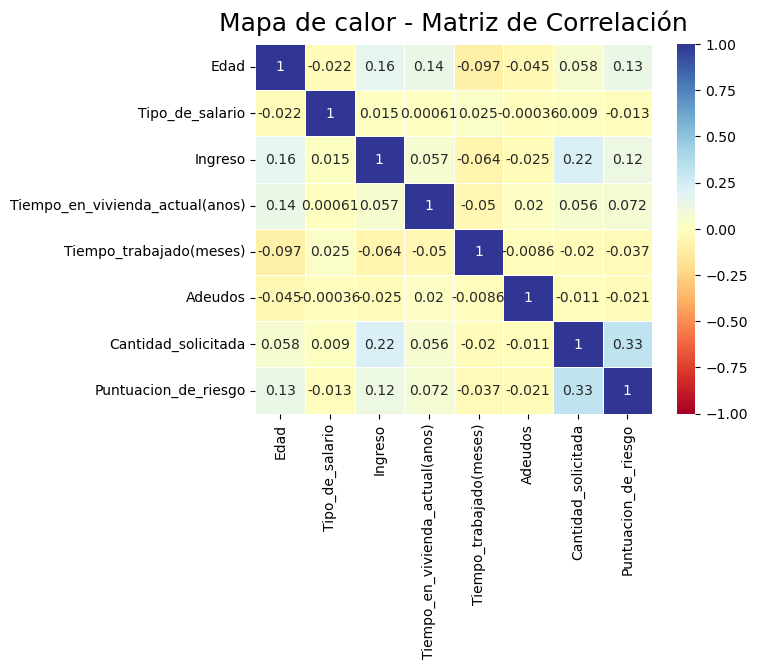

In [88]:
#plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(matriz_correlacion, vmin=-1, vmax=1, annot=True, cmap='RdYlBu', linewidth=.5)
heatmap.set_title('Mapa de calor - Matriz de Correlación', fontdict={'fontsize':18}, pad=10)

Gracias a esta matriz se puede demostrar que variables estan realacionadas entre si dependiendo la escala de color.
En todas siempre se mostrara la linea diagonal como una relacion perfecta ya que se estan comparando entre las mismas columnas, pero como se puede ver las variables mas relacionadas son "Cantidad solicitada" y "Puntuacion de riesgo"

### ¿Qué significan los números de las correlaciones?

La correlación se describe mediante una medida sin unidades llamada coeficiente de correlación, que va desde -1 a +1.

* 1 = Existe una correlación directa fuerte.
* -1 = Existe una correlación inversa fuerte. 
* 0 = No existe una correlación lineal (Solamente no existe una relación lineal, puede que tengan otro tipo de relación los datos).

### ¿Cómo interpretar los resultados de los coeficientes?

A la hora de interpretar los valores del coeficiente de correlación de Pearson (Tabla de arriba), se pueden utilizar los siguientes criterios.

- Entre 0 y 0,10: correlación inexistente
- Entre 0,10 y 0,29: correlación débil
- Entre 0,30 y 0,50: correlación moderada
- Entre 0,50 y 1,00: correlación fuerte

Esto mismo aplica de forma negativa (inversa).

### ¿Cómo interpretar los resultados del gráfico?

En el gráfico que muestra la matriz de correlación, se le aplico colores que pasen del rojo, amarillo en el cero, hasta azul, para poder visualizar los coeficientes tanto bajos, nulos y altos respectivamente.

Por ejemplo, se puede ver que existe una correlación nula entre los adeudos de una persona y su edad correspondiente.

## Seleccionando características


### Separación de los datos
Es importante que antes de comenzar con el procesamiento de datos, se separe el conjunto de datos con las variables dependientes e independientes.

In [89]:
# Datos de entrada o independientes
# Por el momento todas
X = df.iloc[:,:-1]
X.head()

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado
0,-0.218243,0,1,-0.225295,-0.500617,-0.209055,-0.199607,1.138055,-0.774893,1,-0.606683,-1.644121,0.517540,0.476796,-0.745387,-1.657174,-0.301214,-1.740516,0.969196
1,1.547775,3,0,-0.189006,-0.500617,1.131228,-0.199607,-0.652202,1.817114,1,-0.487447,-2.062694,0.529888,0.059823,1.060174,0.912922,0.782769,0.067290,0.695771
2,-1.647877,3,0,-1.511531,1.992550,-1.549339,-1.299468,1.585619,-1.293294,1,-0.845154,-1.758277,-0.530983,-2.062494,0.112997,0.382071,-0.657273,-0.649227,0.148920
3,-0.218243,0,0,1.464151,-0.500617,1.131228,-0.932848,-0.652202,1.817114,1,-0.248976,-1.232466,-0.284080,1.539411,1.495381,0.519068,1.230192,-0.208930,0.422345
4,-0.806916,2,0,0.141625,-0.500617,0.684467,-0.566227,-0.652202,2.335515,1,0.704910,-0.422993,-0.815668,-0.375252,0.260737,-0.419035,0.883452,0.891681,1.516047


In [90]:
# Datos de salida o dependientes
# Solamente la columna de firma electronica
y = df.iloc[:,-1]
y.head()

0    1
1    0
2    0
3    1
4    0
Name: Proceso_firma_electronica_completado, dtype: int64

## Método de envoltura

### Eliminación de características recursivas (RFE): 

### ¿Qué es? 
Es un algoritmo de optimización que busca encontrar el subconjunto de funciones con mejor rendimiento. 

### ¿Cómo funciona?
Crea repetidamente modelos y deja de lado la mejor o la peor característica de rendimiento en cada iteración. Construye el siguiente modelo con las características de la izquierda hasta que se agotan todas las características, luego clasifica las características según el orden de su eliminación.

### ¿Cómo lo utilizaremos?

Ya que necesita de un modelo para trabajar utilizaremos el modelo de regresión logistica, en cuanto al número de características a seleccionar, consideramos que 6 seria lo suficientemente relevante como para obtener buenos resultados.

In [91]:
# Extraccion de caracteristicas
modelo = LogisticRegression()
rfe = RFE(estimator=modelo,n_features_to_select=6)
entrenamiento = rfe.fit(X.values,y.values)

In [92]:
print("Número de características: %s " %(entrenamiento.n_features_))
print("Características seleccionadas: %s " %(entrenamiento.support_))
print("Clasificación de características: %s " %(entrenamiento.ranking_))


Número de características: 6 
Características seleccionadas: [ True False  True False False False False  True False  True  True  True
 False False False False False False False] 
Clasificación de características: [ 1  6  1  5  7 10  8  1  3  1  1  1 12  2 13 14  4 11  9] 


In [93]:
X.iloc[:,entrenamiento.support_]

,Edad,Vivienda_propia,Tiempo_cuenta_personal(meses),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo
0,-0.218243,1,1.138055,1,-0.606683,-1.644121
1,1.547775,0,-0.652202,1,-0.487447,-2.062694
2,-1.647877,0,1.585619,1,-0.845154,-1.758277
3,-0.218243,0,-0.652202,1,-0.248976,-1.232466
4,-0.806916,0,-0.652202,1,0.704910,-0.422993
...,...,...,...,...,...,...
17902,0.959102,0,0.242926,1,-0.487447,-0.312295
17903,-0.975108,0,-0.652202,1,-0.248976,0.811973
17905,0.286334,0,-1.099766,1,0.943381,-0.021715
17906,-0.050051,0,1.138055,1,-0.964390,1.400051


Agrupando los datos en un dataframe para ver mejor la información, observamos que las columnas seleccionadas por el método de envoltura son las siguientes:

1. Edad
2. Vivienda_propia
3. Tiempo_cuenta_personal(meses)
4. Adeudos
5. Cantidad_solicitada
6. Puntuacion_de_riesgo

Por lo que solo preservaremos estas columnas en el dataframe de las variables independientes (X)

In [94]:
X = X.iloc[:,entrenamiento.support_]
X.head()

,Edad,Vivienda_propia,Tiempo_cuenta_personal(meses),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo
0,-0.218243,1,1.138055,1,-0.606683,-1.644121
1,1.547775,0,-0.652202,1,-0.487447,-2.062694
2,-1.647877,0,1.585619,1,-0.845154,-1.758277
3,-0.218243,0,-0.652202,1,-0.248976,-1.232466
4,-0.806916,0,-0.652202,1,0.704910,-0.422993


Observamos que todavia preservamos la misma cantidad de datos.

In [95]:
X.shape

(15500, 6)

## Procesamiento de los datos

### Datos de entrenamiento y de prueba

Separamos los datos en datos de entrenamiento para el modelo y los de prueba que serviran para demostrar la efectividad del modelo aplicado.

In [96]:
# Separación de datos de entrenamiento y de prueba con 25% de ellos
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)

## Algoritmos de clasificación.

###  Regresión Logistica
Este es el algoritmo mas basico de todos, sin embargo, es tambien de los mas utilizados ya que es de los mas faciles de implementar y se puede usar como linea base para cualquier problema de clasificacion.

Primero, inicializamos el modelo y aplicamos el método fit para ajustar los datos, nos pide como variables los datos de entrenamiento que separamos anteriormente, tanto x como y. 

Una vez terminado el proceso del algoritmo ejecutamos el método predict y le pasamos los datos de prueba para verificar si obtuvo buenos resultados.

In [97]:
modelo = LogisticRegression()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

 Imprimimos tanto el arreglo de los datos de entrenamiento, como los predecidos por el algoritmo.

In [98]:
print("Datos de entrenamiento")
print(y_test)
print()
print("Datos obtenidos en la predicción")
print(y_pred)

Datos de entrenamiento
[0 1 1 ... 0 0 1]

Datos obtenidos en la predicción
[0 0 1 ... 0 1 1]


#### Métricas de rendimiento del algoritmo  

##### Matriz de confusión
Es de las métricas de medicion mas sencillas de usar, sirve para comprobar la precision y exactitud del modelo usado y se usa cuando el problema de clasificacion tiene 2 o mas tipos de clases.

In [99]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print(matriz_confusion)


[[ 637  857]
 [ 460 1146]]


##### Reporte de clasificación 
Este permite dar rapidamente una idea de la precision de un modelo mediante una serie de medidas, muestra la precision, sensibilidadm puntuacion F1, y el soporte para cada clase.

In [100]:
reporte_clasificacion = classification_report(y_test, y_pred)
print(reporte_clasificacion) 

              precision    recall  f1-score   support

           0       0.58      0.43      0.49      1494
           1       0.57      0.71      0.64      1606

    accuracy                           0.58      3100
   macro avg       0.58      0.57      0.56      3100
weighted avg       0.58      0.58      0.57      3100



##### Area bajo la curva
Permite medir el rendimiento del modelo de clasificacion, y es de hecho, una de las metricas mas importantes para esto.

In [101]:
area_bajo_la_curva = roc_auc_score(y_test, y_pred)
print(area_bajo_la_curva)

0.5699731262117794


### Máquinas de vectores de soporte
Estas buscan la linea que mejor separa dos clases.
Las caracteristicas de datos que estan mas cerca de la linea que mejor separa las clases se denominan vectores de soporte e influyen en la ubicación de la línea.

In [102]:
modelo = SVC()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

####  Métricas de rendimento del algoritmo

##### Matriz de confusión

In [103]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print(matriz_confusion)

[[ 688  806]
 [ 419 1187]]


##### Reporte de clasificación

In [104]:
reporte_clasificacion = classification_report(y_test, y_pred)
print(reporte_clasificacion) 

              precision    recall  f1-score   support

           0       0.62      0.46      0.53      1494
           1       0.60      0.74      0.66      1606

    accuracy                           0.60      3100
   macro avg       0.61      0.60      0.59      3100
weighted avg       0.61      0.60      0.60      3100



##### Area bajo la curva 

In [105]:
area_bajo_la_curva = roc_auc_score(y_test, y_pred)
print(area_bajo_la_curva)

0.5998060319317953


Observando los datos anterior podemos ver que cada uno de los algoritmos nos ofrecen resultados similares, pero aunque se pueda manejar en este caso el primero de Regresión logística ya que se trata de un modelo para clasificación de tipo binario, el algoritmo de vectores de soporte nos ofrece un mayor porcentaje de efectividad al ingresar la misma cantidad de elementos para su entrenamiento.

En cuanto al porcentaje de precisión del procedimiento se puede considerar un poco bajo, sin embargo, hemos llegado con el algoritmo de vectores de soporte a un porcentaje de efectividad, lo que mejora (almenos un poco) nuestro trabajo realizado anteriormente , quiza esto cambiaria al darle menor cantidad de caracteristicas a evaluar ya que esto influye muchisimo, en cuanto más características coloquemos, más ruido tendran los datos, sin embargo, no consideramos adecuado que todo un dataset se evalue, realizando predicciones con pocas características, ya que de cierta manera, todo influye realmente, en este caso, para el proceso de firma electronica.